In [23]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot


from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

import optuna
import xgboost as xgb
import catboost
from catboost import CatBoostRegressor

import warnings
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


In [24]:
train_wOrdinal = pd.read_csv('~/Documents/AmesHousingML/clean_data_ordinal.csv') 
train_originalCleaned = pd.read_csv('~/Documents/AmesHousingML/clean_data_original.csv') 
train_wOnlyDummies = pd.read_csv('~/Documents/AmesHousingML/clean_data_dummified.csv') 
train_wOnlyDummiesNoDrop = pd.read_csv('~/Documents/AmesHousingML/clean_data_dummified_noDrop.csv') 

In [25]:
print(train_originalCleaned.shape)
print(train_wOnlyDummies.shape)
print(train_wOrdinal.shape)
print(train_wOnlyDummiesNoDrop.shape)

(2576, 86)
(2576, 266)
(2576, 86)
(2576, 307)


## Finding & Dealing with Outliers

In [26]:
outlier_threshold = 3

In [27]:
Q1 = train_wOrdinal['SalePrice'].quantile(.25)
Q3 = train_wOrdinal['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + outlier_threshold * IQR

In [28]:
before_outlier_total = train_wOrdinal.count()[1]
train_wOrdinal.drop(train_wOrdinal[train_wOrdinal['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train_wOrdinal.count()[1]

In [29]:
before_outlier_total - post_outlier_total

23

In [30]:
Q1 = train_originalCleaned['SalePrice'].quantile(.25)
Q3 = train_originalCleaned['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + outlier_threshold * IQR

In [31]:
before_outlier_total = train_originalCleaned.count()[1]
train_originalCleaned.drop(train_originalCleaned[train_originalCleaned['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train_originalCleaned.count()[1]

In [32]:
before_outlier_total - post_outlier_total

23

In [33]:
Q1 = train_wOnlyDummies['SalePrice'].quantile(.25)
Q3 = train_wOnlyDummies['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + outlier_threshold * IQR

In [34]:
before_outlier_total = train_wOnlyDummies.count()[1]
train_wOnlyDummies.drop(train_wOnlyDummies[train_wOnlyDummies['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train_wOnlyDummies.count()[1]

In [35]:
before_outlier_total - post_outlier_total

23

In [36]:
Q1 = train_wOnlyDummiesNoDrop['SalePrice'].quantile(.25)
Q3 = train_wOnlyDummiesNoDrop['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + outlier_threshold * IQR

In [37]:
before_outlier_total = train_wOnlyDummiesNoDrop.count()[1]
train_wOnlyDummiesNoDrop.drop(train_wOnlyDummiesNoDrop[train_wOnlyDummiesNoDrop['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train_wOnlyDummiesNoDrop.count()[1]

In [38]:
before_outlier_total - post_outlier_total

23

In [39]:
masterScores = pd.DataFrame(columns = ['Model', 'r2_5kf_mean', 'rmse_5kf_mean'])

In [43]:
ourFrames = [train_wOrdinal, train_wOnlyDummies, train_wOnlyDummiesNoDrop]   #, train_originalCleaned]

In [44]:
for frame in ourFrames:
    frame = frame.drop('PID', axis=1)
    

In [45]:
for frame in ourFrames:
    #the features will be X (independent variables)
    X = frame.drop('SalePrice', axis=1)
    X_array = X.values
    #the target (dependent variable) will be y
    y = frame['SalePrice']
    y_array = y.values

    #Split your training and testing sets of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'RMSE',  # Use appropriate loss function for your task
    'random_seed': 42
                        }

    cat_model = CatBoostRegressor(**params)

    # Train the model on the training set
    cat_model.fit(X_train, y_train)

    # Make predictions on the test set
    cat_model_y_pred = cat_model.predict(X_test)

    # Evaluate the Random Forest model
    cat_model_r2 = r2_score(y_test, cat_model_y_pred)
    print(f'R-squared on the test set: {cat_model_r2}')

    cat_model_mse = mean_squared_error(y_test, cat_model_y_pred)
    print(f'Mean Squared Error on the test set: {cat_model_mse}')

    # Root Mean Squared Error (RMSE) on the test set
    cat_model_rmse = mean_squared_error(y_test, cat_model_y_pred, squared=False)
    print("Root Mean Squared Error (RMSE) on the test set:", cat_model_rmse)

    # Display feature importances
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': cat_model.feature_importances_})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    print('\nFeature Importances:')
    print(feature_importances)
    
    
    # Create a KFold object
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_scores = cross_val_score(cat_model, X, y, cv=kf, scoring='r2')
    # You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

    # Display the cross-validation scores
    print("Cross-Validation Scores:", cv_scores, '\n')

    # Print the mean and standard deviation of the scores
    print(f"Mean R^2: {cv_scores.mean()}", '\n')
    print(f"Standard Deviation R^2: {cv_scores.std()}")
    
        
    print('\n')
    print('\n')
    print('\n')
    
    # feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
    # feat_importances.nlargest(20).plot(kind='barh')

0:	learn: 61970.7435896	total: 3.25ms	remaining: 322ms
1:	learn: 57667.6038687	total: 5.73ms	remaining: 281ms
2:	learn: 53860.3444070	total: 8.43ms	remaining: 273ms
3:	learn: 50598.9718643	total: 11.6ms	remaining: 279ms
4:	learn: 47370.6685085	total: 14.8ms	remaining: 281ms
5:	learn: 44683.2199857	total: 16.9ms	remaining: 266ms
6:	learn: 42099.1853782	total: 18.8ms	remaining: 250ms
7:	learn: 39573.8151129	total: 21ms	remaining: 242ms
8:	learn: 37626.0340312	total: 23.4ms	remaining: 236ms
9:	learn: 35823.0470166	total: 26ms	remaining: 234ms
10:	learn: 34167.0812928	total: 28.2ms	remaining: 228ms
11:	learn: 32621.5121021	total: 30.8ms	remaining: 226ms
12:	learn: 31244.6639554	total: 34.1ms	remaining: 228ms
13:	learn: 30028.7961478	total: 36.9ms	remaining: 226ms
14:	learn: 28928.7873675	total: 40.7ms	remaining: 231ms
15:	learn: 27936.8839310	total: 43.2ms	remaining: 227ms
16:	learn: 26969.6430596	total: 46.2ms	remaining: 226ms
17:	learn: 26144.0874527	total: 49.1ms	remaining: 224ms
18:	le

In [46]:
train_wOrdinal.head()

PID  GrLivArea  SalePrice  MSSubClass  MSZoning  LotFrontage  \
0  909176150        856     126000          30         5         60.0   
1  905476230       1049     139500         120         5         42.0   
2  911128020       1001     124900          30         1         60.0   
3  535377150       1039     114000          70         5         80.0   
4  534177230       1665     227000          60         5         70.0   

   LotArea  Street  Alley  LotShape  LandContour  Utilities  LotConfig  \
0     7890       1      1         3            3          0          0   
1     4235       1      1         3            3          0          4   
2     6060       1      1         3            3          0          4   
3     8146       1      1         3            3          0          0   
4     8400       1      1         3            3          0          4   

   LandSlope  Neighborhood  Condition1  Condition2  BldgType  HouseStyle  \
0          0            19           2           2         0           2   
1          0             7           2           2         4           2   
2          0            10           2           2         0           2   
3          0            18           2           2         0           5   
4          0            15           2           2         0           5   

   OverallQual  OverallCond  YearBuilt  YearRemodAdd  RoofStyle  RoofMatl  \
0            6            6       1939          1950          1         0   
1            5            5       1984          1984          1         0   
2            5            9       1930          2007          3         0   
3            4            8       1900          2003          1         0   
4            8            6       2001          2001          1         0   

   Exterior1st  Exterior2nd  MasVnrType  MasVnrArea  ExterQual  ExterCond  \
0           13           14           2         0.0          3          3   
1            6            6           1       149.0          4          3   
2            8            8           2         0.0          4          3   
3            8            8           2         0.0          4          4   
4           12           13           2         0.0          4          3   

   Foundation  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  \
0           1         4         4             2             3       238.0   
1           1         5         4             3             3       552.0   
2           0         4         4             2             2       737.0   
3           0         3         4             2             1         0.0   
4           2         5         4             2             3       643.0   

   BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  Heating  HeatingQC  \
0             1         0.0      618.0        856.0        1          3   
1             2       393.0      104.0       1049.0        1          3   
2             1         0.0      100.0        837.0        1          5   
3             1         0.0      405.0        405.0        1          4   
4             1         0.0      167.0        810.0        1          5   

   CentralAir  Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  BsmtFullBath  \
0           1           3       856         0             0           1.0   
1           1           3      1049         0             0           1.0   
2           1           3      1001         0             0           0.0   
3           1           3       717       322             0           0.0   
4           1           3       810       855             0           1.0   

   BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  \
0           0.0         1         0             2             1            3   
1           0.0         2         0             2             1            4   
2           0.0         1         0             2             1            4   
3           0.0         1         0          

In [54]:
#name the model for our scores tracker
model_name = 'catboost'
train_wOrdinal = train_wOrdinal.drop('PID', axis=1)
    #the features will be X (independent variables)
X = train_wOrdinal.drop('SalePrice', axis=1)
X_array = X.values
#the target (dependent variable) will be y
y = train_wOrdinal['SalePrice']
y_array = y.values

#Split your training and testing sets of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'RMSE',  # Use appropriate loss function for your task
    'random_seed': 42
                        }

cat_model = CatBoostRegressor(**params)

# Train the model on the training set
cat_model.fit(X_train, y_train)

# Make predictions on the test set
cat_model_y_pred = cat_model.predict(X_test)

# Evaluate the Random Forest model
cat_model_r2 = r2_score(y_test, cat_model_y_pred)
print(f'R-squared on the test set: {cat_model_r2}')

cat_model_mse = mean_squared_error(y_test, cat_model_y_pred)
print(f'Mean Squared Error on the test set: {cat_model_mse}')

# Root Mean Squared Error (RMSE) on the test set
cat_model_rmse = mean_squared_error(y_test, cat_model_y_pred, squared=False)
print("Root Mean Squared Error (RMSE) on the test set:", cat_model_rmse)

# Display feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': cat_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print('\nFeature Importances:')
print(feature_importances)



# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(cat_model, X, y, cv=kf, scoring='r2')
# You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

def rmse_scorer(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        return rmse
    
    
# Define the scoring function using neg_mean_squared_error
scorer = make_scorer(rmse_scorer)
# Use cross_val_score with the defined scorer
rmse_scores = cross_val_score(cat_model, X, y, cv=kf, scoring=scorer)



# Display the cross-validation scores
print("Cross-Validation Scores Rsquared:", cv_scores, '\n')
print("Cross-Validation Scores RMSE:", rmse_scores, '\n')

# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n')
print(f"Standard Deviation R^2: {cv_scores.std()}", '\n')
print(f"Mean RMSE: {rmse_scores.mean()}")

record = {'Model': model_name, 'r2_5kf_mean': cv_scores.mean(), 'rmse_5kf_mean': rmse_scores.mean()}
masterScores = masterScores.append(record, ignore_index=True)

0:	learn: 61768.5516119	total: 3.24ms	remaining: 321ms
1:	learn: 57665.6124876	total: 5.53ms	remaining: 271ms
2:	learn: 54157.9846825	total: 7.35ms	remaining: 238ms
3:	learn: 50575.1373381	total: 9.01ms	remaining: 216ms
4:	learn: 47562.1182462	total: 10.8ms	remaining: 206ms
5:	learn: 44628.9366488	total: 12.6ms	remaining: 197ms
6:	learn: 42069.2583409	total: 14.4ms	remaining: 191ms
7:	learn: 39654.6553343	total: 16.2ms	remaining: 186ms
8:	learn: 37579.6071721	total: 18.2ms	remaining: 184ms
9:	learn: 35716.5244647	total: 20ms	remaining: 180ms
10:	learn: 34137.1101658	total: 21.9ms	remaining: 177ms
11:	learn: 32617.5469968	total: 23.7ms	remaining: 174ms
12:	learn: 31292.5709904	total: 25.3ms	remaining: 169ms
13:	learn: 30063.0325520	total: 26.9ms	remaining: 166ms
14:	learn: 28849.5406711	total: 28.6ms	remaining: 162ms
15:	learn: 27868.5587294	total: 30.9ms	remaining: 162ms
16:	learn: 27097.5507627	total: 32.5ms	remaining: 159ms
17:	learn: 26279.9063750	total: 34.3ms	remaining: 156ms
18:	

In [56]:
masterScores #want to use the sci kit and catboost

Model  r2_5kf_mean  rmse_5kf_mean
0  catboost     0.919533   18889.778029

In [ ]:
output_file = 'masterScores_catboost.csv'

masterScores.to_csv(output_file, index=False, mode='w')

print(f"DataFrame exported to '{output_file}' in the same working directory.")

In [57]:

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
    }

    model = CatBoostRegressor(**params, random_state=42)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=10)

    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse

study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=100)

best_params = study.best_params
best_model = CatBoostRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

[I 2024-01-29 09:47:07,853] A new study created in memory with name: no-name-f5b9f780-6110-4e8c-b7f9-a226984c8449


0:	learn: 63041.9906141	test: 65817.8361632	best: 65817.8361632 (0)	total: 19.4ms	remaining: 3.22s
10:	learn: 38883.9972381	test: 42362.9364659	best: 42362.9364659 (10)	total: 84.7ms	remaining: 1.2s
20:	learn: 27592.4238024	test: 31121.6661140	best: 31121.6661140 (20)	total: 188ms	remaining: 1.31s
30:	learn: 22080.8633723	test: 25667.7730234	best: 25667.7730234 (30)	total: 306ms	remaining: 1.34s
40:	learn: 19231.5528868	test: 22909.0708589	best: 22909.0708589 (40)	total: 394ms	remaining: 1.21s
50:	learn: 17345.6936175	test: 21636.1833760	best: 21636.1833760 (50)	total: 429ms	remaining: 975ms
60:	learn: 16002.1489217	test: 20880.3645585	best: 20880.3645585 (60)	total: 462ms	remaining: 803ms
70:	learn: 15050.2826578	test: 20264.2300628	best: 20264.2300628 (70)	total: 502ms	remaining: 678ms
80:	learn: 14226.1218381	test: 19748.5296689	best: 19748.5296689 (80)	total: 536ms	remaining: 569ms
90:	learn: 13553.9421015	test: 19425.1182189	best: 19425.1182189 (90)	total: 569ms	remaining: 475ms
1

[I 2024-01-29 09:47:08,714] Trial 0 finished with value: 320613548.4132842 and parameters: {'iterations': 167, 'learning_rate': 0.07448128753625897, 'depth': 8}. Best is trial 0 with value: 320613548.4132842.


150:	learn: 10396.1670660	test: 18046.6612771	best: 18046.6612771 (150)	total: 767ms	remaining: 81.3ms
160:	learn: 10023.2567361	test: 17961.6162378	best: 17961.6162378 (160)	total: 799ms	remaining: 29.8ms
166:	learn: 9803.7646848	test: 17905.6848072	best: 17905.6848072 (166)	total: 819ms	remaining: 0us

bestTest = 17905.68481
bestIteration = 166

0:	learn: 62477.7432077	test: 65245.8557623	best: 65245.8557623 (0)	total: 4.92ms	remaining: 1.17s
10:	learn: 35986.7906189	test: 39570.4750698	best: 39570.4750698 (10)	total: 41ms	remaining: 850ms
20:	learn: 25148.8801931	test: 29040.1936865	best: 29040.1936865 (20)	total: 74.5ms	remaining: 774ms
30:	learn: 20371.0106357	test: 24714.3350156	best: 24714.3350156 (30)	total: 107ms	remaining: 716ms
40:	learn: 17866.2801996	test: 22586.5776167	best: 22586.5776167 (40)	total: 141ms	remaining: 681ms
50:	learn: 16272.0459935	test: 21319.9420482	best: 21319.9420482 (50)	total: 192ms	remaining: 709ms
60:	learn: 15220.2677092	test: 20654.0789974	best: 

[I 2024-01-29 09:47:09,513] Trial 1 finished with value: 321741219.50813633 and parameters: {'iterations': 239, 'learning_rate': 0.08644385892721862, 'depth': 8}. Best is trial 0 with value: 320613548.4132842.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 17937.14636
bestIteration = 205

Shrink model to first 206 iterations.
0:	learn: 60898.3416803	test: 63608.8542741	best: 63608.8542741 (0)	total: 15ms	remaining: 3.74s
10:	learn: 29940.5875189	test: 32749.7794217	best: 32749.7794217 (10)	total: 75.6ms	remaining: 1.65s
20:	learn: 20867.5681891	test: 24739.8565528	best: 24739.8565528 (20)	total: 132ms	remaining: 1.44s
30:	learn: 17097.7274406	test: 21898.1441222	best: 21898.1441222 (30)	total: 189ms	remaining: 1.34s
40:	learn: 15076.8800016	test: 20734.6991626	best: 20734.6991626 (40)	total: 247ms	remaining: 1.27s
50:	learn: 13707.7327226	test: 19990.9165279	best: 19990.9165279 (50)	total: 304ms	remaining: 1.19s
60:	learn: 12619.2962340	test: 19696.7038586	best: 19696.7038586 (60)	total: 360ms	remaining: 1.12s
70:	learn: 11594.9503141	test: 19278.7355678	best: 19278.7355678 (70)	total: 416ms	remaining: 1.05s
80:	learn: 10603.8242777	test: 19053.9082515	best: 19053.9082515 

[I 2024-01-29 09:47:10,415] Trial 2 finished with value: 333151142.8392064 and parameters: {'iterations': 251, 'learning_rate': 0.12065101049804607, 'depth': 9}. Best is trial 0 with value: 320613548.4132842.


150:	learn: 6512.3103036	test: 18258.7882322	best: 18252.4284094 (140)	total: 879ms	remaining: 582ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 18252.42841
bestIteration = 140

Shrink model to first 141 iterations.
0:	learn: 56636.8400909	test: 59297.7230889	best: 59297.7230889 (0)	total: 1.57ms	remaining: 598ms
10:	learn: 23293.9579703	test: 25041.2510819	best: 25041.2510819 (10)	total: 11.8ms	remaining: 397ms
20:	learn: 18903.5109911	test: 20721.6857574	best: 20721.6857574 (20)	total: 22.6ms	remaining: 388ms
30:	learn: 16877.3522680	test: 19593.6408270	best: 19593.6408270 (30)	total: 32.6ms	remaining: 369ms
40:	learn: 15528.2546150	test: 19000.3034028	best: 19000.3034028 (40)	total: 43ms	remaining: 356ms
50:	learn: 14270.4428922	test: 18293.5960697	best: 18293.5960697 (50)	total: 53.6ms	remaining: 347ms
60:	learn: 13482.5743440	test: 17853.7581182	best: 17853.7581182 (60)	total: 65ms	remaining: 341ms
70:	learn: 12709.0894175	test: 17806.8961634	best: 17805.9625

[I 2024-01-29 09:47:10,635] Trial 3 finished with value: 291007133.1013289 and parameters: {'iterations': 381, 'learning_rate': 0.22271054604562845, 'depth': 5}. Best is trial 3 with value: 291007133.1013289.


170:	learn: 8237.9783871	test: 17081.6920573	best: 17081.6920573 (170)	total: 182ms	remaining: 224ms
180:	learn: 7936.3135646	test: 17058.9311829	best: 17058.9311829 (180)	total: 193ms	remaining: 213ms
190:	learn: 7726.8827833	test: 17073.7923890	best: 17058.9311829 (180)	total: 204ms	remaining: 203ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 17058.93118
bestIteration = 180

Shrink model to first 181 iterations.
0:	learn: 61274.3943568	test: 64015.1765268	best: 64015.1765268 (0)	total: 1.63ms	remaining: 773ms
10:	learn: 31742.4873302	test: 33999.0434805	best: 33999.0434805 (10)	total: 11.5ms	remaining: 486ms
20:	learn: 23138.7726606	test: 25068.6728746	best: 25068.6728746 (20)	total: 21.7ms	remaining: 469ms
30:	learn: 19991.3125284	test: 21959.6605026	best: 21959.6605026 (30)	total: 32.6ms	remaining: 465ms
40:	learn: 18281.9152075	test: 20402.0940025	best: 20402.0940025 (40)	total: 42.9ms	remaining: 453ms
50:	learn: 17225.1882822	test: 19743.9806294	best: 19743.

[I 2024-01-29 09:47:10,861] Trial 4 finished with value: 293920778.97898 and parameters: {'iterations': 474, 'learning_rate': 0.11670227539572267, 'depth': 5}. Best is trial 3 with value: 291007133.1013289.


160:	learn: 11443.0175056	test: 17277.7427466	best: 17277.7427466 (160)	total: 172ms	remaining: 334ms
170:	learn: 11234.8935621	test: 17223.3973298	best: 17223.3973298 (170)	total: 182ms	remaining: 323ms
180:	learn: 10964.8307959	test: 17192.4451025	best: 17187.2142857 (178)	total: 194ms	remaining: 315ms
190:	learn: 10679.1637691	test: 17163.3143190	best: 17144.1179120 (187)	total: 205ms	remaining: 304ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 17144.11791
bestIteration = 187

Shrink model to first 188 iterations.
0:	learn: 62417.1368549	test: 65184.4152283	best: 65184.4152283 (0)	total: 5.5ms	remaining: 792ms
10:	learn: 35617.2490326	test: 39308.6391195	best: 39308.6391195 (10)	total: 41.8ms	remaining: 510ms
20:	learn: 25124.6474508	test: 29024.9780334	best: 29024.9780334 (20)	total: 75.5ms	remaining: 446ms
30:	learn: 20391.1079793	test: 24828.8066469	best: 24828.8066469 (30)	total: 109ms	remaining: 400ms
40:	learn: 17871.5930091	test: 22709.2271068	best: 2270

[I 2024-01-29 09:47:11,373] Trial 5 finished with value: 345561241.49799144 and parameters: {'iterations': 145, 'learning_rate': 0.08773121597800247, 'depth': 8}. Best is trial 3 with value: 291007133.1013289.


110:	learn: 11453.9315807	test: 19027.1745731	best: 19027.1745731 (110)	total: 384ms	remaining: 118ms
120:	learn: 10944.2739079	test: 18962.1590222	best: 18955.0750038 (117)	total: 417ms	remaining: 82.8ms
130:	learn: 10471.8913540	test: 18836.9034067	best: 18836.9034067 (130)	total: 450ms	remaining: 48.1ms
140:	learn: 9967.7750607	test: 18629.8631109	best: 18629.8631109 (140)	total: 483ms	remaining: 13.7ms
144:	learn: 9800.5382848	test: 18589.2775948	best: 18589.2775948 (144)	total: 496ms	remaining: 0us

bestTest = 18589.27759
bestIteration = 144

0:	learn: 60876.6995971	test: 63610.9786093	best: 63610.9786093 (0)	total: 1.15ms	remaining: 385ms
10:	learn: 30763.4777371	test: 33335.8268666	best: 33335.8268666 (10)	total: 11.4ms	remaining: 336ms
20:	learn: 22525.4855424	test: 24801.5396004	best: 24801.5396004 (20)	total: 22.4ms	remaining: 335ms
30:	learn: 19531.3599125	test: 21907.3159052	best: 21907.3159052 (30)	total: 33.1ms	remaining: 325ms
40:	learn: 17755.2248048	test: 20352.9810954

[I 2024-01-29 09:47:11,544] Trial 6 finished with value: 300296110.2048294 and parameters: {'iterations': 335, 'learning_rate': 0.1256134219525648, 'depth': 5}. Best is trial 3 with value: 291007133.1013289.


70:	learn: 15078.2073434	test: 18515.2234327	best: 18515.2234327 (70)	total: 76.1ms	remaining: 283ms
80:	learn: 14334.6500512	test: 18118.9935094	best: 18118.9935094 (80)	total: 87ms	remaining: 273ms
90:	learn: 13756.4423030	test: 17911.0763797	best: 17911.0763797 (90)	total: 97.2ms	remaining: 261ms
100:	learn: 13250.8891641	test: 17701.6638407	best: 17701.6638407 (100)	total: 107ms	remaining: 249ms
110:	learn: 12825.2114626	test: 17557.8531470	best: 17557.8531470 (110)	total: 118ms	remaining: 238ms
120:	learn: 12419.2453614	test: 17507.5373981	best: 17507.5373981 (120)	total: 129ms	remaining: 227ms
130:	learn: 11991.7708961	test: 17450.2196058	best: 17440.3085074 (127)	total: 139ms	remaining: 216ms
140:	learn: 11646.8195123	test: 17357.5363311	best: 17329.0539328 (139)	total: 149ms	remaining: 205ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 17329.05393
bestIteration = 139

Shrink model to first 140 iterations.
0:	learn: 61067.2200320	test: 63815.7249185	best: 63

[I 2024-01-29 09:47:11,840] Trial 7 finished with value: 359650137.4866573 and parameters: {'iterations': 86, 'learning_rate': 0.11653365120179984, 'depth': 8}. Best is trial 3 with value: 291007133.1013289.


40:	learn: 15897.3131566	test: 21009.2838915	best: 21009.2838915 (40)	total: 135ms	remaining: 149ms
50:	learn: 14554.3913420	test: 20296.0732357	best: 20296.0732357 (50)	total: 168ms	remaining: 116ms
60:	learn: 13537.6965638	test: 19822.3653349	best: 19797.1260046 (59)	total: 201ms	remaining: 82.5ms
70:	learn: 12642.4550063	test: 19385.6568097	best: 19385.6568097 (70)	total: 234ms	remaining: 49.5ms
80:	learn: 11874.4804190	test: 19174.9972085	best: 19169.6434394 (78)	total: 267ms	remaining: 16.5ms
85:	learn: 11466.3666021	test: 18964.4440332	best: 18964.4440332 (85)	total: 284ms	remaining: 0us

bestTest = 18964.44403
bestIteration = 85

0:	learn: 60161.4733106	test: 62884.3942021	best: 62884.3942021 (0)	total: 836us	remaining: 140ms
10:	learn: 29619.0589855	test: 32616.8314398	best: 32616.8314398 (10)	total: 8.53ms	remaining: 122ms
20:	learn: 22647.5510848	test: 25015.4934166	best: 25015.4934166 (20)	total: 16ms	remaining: 112ms
30:	learn: 20062.9116303	test: 22094.1842689	best: 22094.

[I 2024-01-29 09:47:11,987] Trial 8 finished with value: 319093466.46044123 and parameters: {'iterations': 168, 'learning_rate': 0.14206168105792205, 'depth': 4}. Best is trial 3 with value: 291007133.1013289.


50:	learn: 17658.4226183	test: 20314.4835955	best: 20314.4835955 (50)	total: 41.3ms	remaining: 94.7ms
60:	learn: 16826.4015648	test: 19796.0341208	best: 19796.0341208 (60)	total: 49.3ms	remaining: 86.5ms
70:	learn: 15996.6604461	test: 19262.7543487	best: 19262.7543487 (70)	total: 58.6ms	remaining: 80ms
80:	learn: 15380.6755628	test: 18816.5085187	best: 18816.5085187 (80)	total: 67.1ms	remaining: 72.1ms
90:	learn: 14846.6831538	test: 18596.6870246	best: 18596.6870246 (90)	total: 74.8ms	remaining: 63.3ms
100:	learn: 14279.0005262	test: 18463.4652695	best: 18414.8879757 (96)	total: 82.4ms	remaining: 54.7ms
110:	learn: 13824.3667091	test: 18315.6097330	best: 18314.7126991 (107)	total: 90.4ms	remaining: 46.4ms
120:	learn: 13408.7790715	test: 18222.7132634	best: 18215.0050659 (118)	total: 98.7ms	remaining: 38.3ms
130:	learn: 13037.9266819	test: 18098.3650276	best: 18098.3650276 (130)	total: 107ms	remaining: 30.1ms
140:	learn: 12676.9600154	test: 17975.5605286	best: 17975.5605286 (140)	total:

[I 2024-01-29 09:47:12,249] Trial 9 finished with value: 301032452.5775357 and parameters: {'iterations': 286, 'learning_rate': 0.2215737647640203, 'depth': 6}. Best is trial 3 with value: 291007133.1013289.


70:	learn: 11675.3681852	test: 18132.0315789	best: 18132.0315789 (70)	total: 107ms	remaining: 323ms
80:	learn: 11054.5134615	test: 17957.8403202	best: 17933.5596672 (77)	total: 122ms	remaining: 309ms
90:	learn: 10522.9581381	test: 17831.8918400	best: 17831.8918400 (90)	total: 137ms	remaining: 294ms
100:	learn: 9796.5511537	test: 17692.8945398	best: 17691.6250977 (99)	total: 151ms	remaining: 277ms
110:	learn: 9124.7751611	test: 17660.9880493	best: 17660.9880493 (110)	total: 166ms	remaining: 261ms
120:	learn: 8631.1714013	test: 17589.5436782	best: 17582.5975208 (116)	total: 180ms	remaining: 245ms
130:	learn: 8222.3606934	test: 17508.9623146	best: 17508.9623146 (130)	total: 194ms	remaining: 230ms
140:	learn: 7809.9441533	test: 17433.8015975	best: 17433.8015975 (140)	total: 209ms	remaining: 215ms
150:	learn: 7378.0613531	test: 17400.5347811	best: 17387.8639825 (143)	total: 223ms	remaining: 200ms
160:	learn: 6975.0196922	test: 17362.0485999	best: 17350.2868154 (158)	total: 238ms	remaining: 

[I 2024-01-29 09:47:13,254] Trial 10 finished with value: 357536191.1239378 and parameters: {'iterations': 444, 'learning_rate': 0.2932224673509834, 'depth': 10}. Best is trial 3 with value: 291007133.1013289.


100:	learn: 3017.2381858	test: 18945.3966262	best: 18908.6274257 (93)	total: 952ms	remaining: 3.23s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 18908.62743
bestIteration = 93

Shrink model to first 94 iterations.
0:	learn: 56696.1214720	test: 59400.3118291	best: 59400.3118291 (0)	total: 1.5ms	remaining: 711ms
10:	learn: 23165.5571830	test: 26251.2372603	best: 26251.2372603 (10)	total: 15.3ms	remaining: 642ms
20:	learn: 18263.8659027	test: 21248.8528027	best: 21248.8528027 (20)	total: 30.2ms	remaining: 652ms
30:	learn: 16463.6996994	test: 19938.5315991	best: 19938.5315991 (30)	total: 44.6ms	remaining: 637ms
40:	learn: 15049.5459560	test: 19177.9530714	best: 19177.9530714 (40)	total: 59ms	remaining: 623ms
50:	learn: 13858.8339874	test: 18500.1194566	best: 18500.1194566 (50)	total: 73.1ms	remaining: 606ms
60:	learn: 12973.7021658	test: 18286.4787224	best: 18286.4787224 (60)	total: 88.2ms	remaining: 597ms
70:	learn: 11885.9479612	test: 17836.4694946	best: 17836.469494

[I 2024-01-29 09:47:13,445] Trial 11 finished with value: 299041761.3039263 and parameters: {'iterations': 474, 'learning_rate': 0.2084819559406063, 'depth': 6}. Best is trial 3 with value: 291007133.1013289.


110:	learn: 9333.7335043	test: 17315.4023702	best: 17292.8239829 (109)	total: 160ms	remaining: 525ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 17292.82398
bestIteration = 109

Shrink model to first 110 iterations.
0:	learn: 65838.2378547	test: 68650.1063268	best: 68650.1063268 (0)	total: 748us	remaining: 290ms
10:	learn: 58932.2657312	test: 61788.9121252	best: 61788.9121252 (10)	total: 8.39ms	remaining: 288ms
20:	learn: 53031.4134316	test: 55923.2090399	best: 55923.2090399 (20)	total: 16.7ms	remaining: 293ms
30:	learn: 48102.2335196	test: 50996.4204686	best: 50996.4204686 (30)	total: 24.4ms	remaining: 282ms
40:	learn: 43955.1568677	test: 46896.6610260	best: 46896.6610260 (40)	total: 32.2ms	remaining: 274ms
50:	learn: 40420.5962887	test: 43435.5240441	best: 43435.5240441 (50)	total: 40.3ms	remaining: 267ms
60:	learn: 37371.5845623	test: 40364.9906357	best: 40364.9906357 (60)	total: 48.3ms	remaining: 260ms
70:	learn: 34819.1211551	test: 37767.6830956	best: 37767.6

[I 2024-01-29 09:47:13,778] Trial 12 finished with value: 400539379.94531196 and parameters: {'iterations': 389, 'learning_rate': 0.01638347811323393, 'depth': 4}. Best is trial 3 with value: 291007133.1013289.


210:	learn: 21569.0296143	test: 23516.0051955	best: 23516.0051955 (210)	total: 170ms	remaining: 144ms
220:	learn: 21221.7617312	test: 23120.2142771	best: 23120.2142771 (220)	total: 178ms	remaining: 135ms
230:	learn: 20919.5515302	test: 22763.2409855	best: 22763.2409855 (230)	total: 186ms	remaining: 127ms
240:	learn: 20638.6893903	test: 22457.1718744	best: 22457.1718744 (240)	total: 195ms	remaining: 119ms
250:	learn: 20346.0161679	test: 22148.0440591	best: 22148.0440591 (250)	total: 203ms	remaining: 111ms
260:	learn: 20095.7058452	test: 21921.4123137	best: 21921.4123137 (260)	total: 210ms	remaining: 103ms
270:	learn: 19872.9411050	test: 21720.3328985	best: 21720.3328985 (270)	total: 218ms	remaining: 95.1ms
280:	learn: 19643.6797122	test: 21486.4184259	best: 21486.4184259 (280)	total: 226ms	remaining: 86.9ms
290:	learn: 19440.6419615	test: 21293.8604565	best: 21293.8604565 (290)	total: 234ms	remaining: 78.8ms
300:	learn: 19237.6417679	test: 21116.5346717	best: 21116.5346717 (300)	total: 

[I 2024-01-29 09:47:13,944] Trial 13 finished with value: 349996873.8610891 and parameters: {'iterations': 401, 'learning_rate': 0.1966067969083281, 'depth': 6}. Best is trial 3 with value: 291007133.1013289.


30:	learn: 16411.5435810	test: 20904.8060920	best: 20904.8060920 (30)	total: 46.3ms	remaining: 552ms
40:	learn: 14922.1500086	test: 20054.5515940	best: 20054.5515940 (40)	total: 61.4ms	remaining: 539ms
50:	learn: 13958.6443725	test: 19581.2869188	best: 19581.2869188 (50)	total: 75.8ms	remaining: 520ms
60:	learn: 12744.0966490	test: 19136.8333643	best: 19136.8333643 (60)	total: 91.3ms	remaining: 509ms
70:	learn: 11972.2364722	test: 18976.1329539	best: 18976.1329539 (70)	total: 106ms	remaining: 493ms
80:	learn: 11275.2202453	test: 18919.0541746	best: 18919.0541746 (80)	total: 121ms	remaining: 477ms
90:	learn: 10568.7854128	test: 18750.1183404	best: 18708.2033841 (89)	total: 136ms	remaining: 464ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 18708.20338
bestIteration = 89

Shrink model to first 90 iterations.
0:	learn: 54883.2468512	test: 57511.0080153	best: 57511.0080153 (0)	total: 1.11ms	remaining: 553ms
10:	learn: 21470.4370684	test: 24033.6352717	best: 24033.63527

[I 2024-01-29 09:47:14,045] Trial 14 finished with value: 317722003.68707156 and parameters: {'iterations': 498, 'learning_rate': 0.26420561034728046, 'depth': 5}. Best is trial 3 with value: 291007133.1013289.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 17824.75817
bestIteration = 69

Shrink model to first 70 iterations.
0:	learn: 59227.6175230	test: 61934.2989879	best: 61934.2989879 (0)	total: 1.22ms	remaining: 441ms
10:	learn: 26789.5533073	test: 28825.4746037	best: 28825.4746037 (10)	total: 11.1ms	remaining: 357ms
20:	learn: 20725.6062393	test: 22521.2402749	best: 22521.2402749 (20)	total: 21.7ms	remaining: 355ms
30:	learn: 18340.4340149	test: 20606.3006154	best: 20606.3006154 (30)	total: 33.4ms	remaining: 359ms
40:	learn: 16954.6515042	test: 19752.3537192	best: 19752.3537192 (40)	total: 44.4ms	remaining: 350ms
50:	learn: 15972.0407168	test: 19126.5930495	best: 19126.5930495 (50)	total: 55.6ms	remaining: 341ms
60:	learn: 15053.0634232	test: 18768.0160180	best: 18768.0160180 (60)	total: 65.7ms	remaining: 326ms
70:	learn: 14106.9820458	test: 18235.3380876	best: 18235.3380876 (70)	total: 76.5ms	remaining: 316ms
80:	learn: 13428.5356444	test: 17934.3511995	best: 17934.35

[I 2024-01-29 09:47:14,268] Trial 15 finished with value: 293440489.0390462 and parameters: {'iterations': 364, 'learning_rate': 0.162899353852515, 'depth': 5}. Best is trial 3 with value: 291007133.1013289.


180:	learn: 9360.5471309	test: 17134.4273670	best: 17134.4273670 (180)	total: 193ms	remaining: 195ms
190:	learn: 9112.1154834	test: 17143.1507603	best: 17130.1047586 (182)	total: 203ms	remaining: 184ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 17130.10476
bestIteration = 182

Shrink model to first 183 iterations.
0:	learn: 58413.7725012	test: 61131.1914238	best: 61131.1914238 (0)	total: 2.11ms	remaining: 743ms
10:	learn: 24499.5770769	test: 27211.2662699	best: 27211.2662699 (10)	total: 23.3ms	remaining: 725ms
20:	learn: 18442.8282478	test: 21673.7002395	best: 21673.7002395 (20)	total: 43.9ms	remaining: 694ms
30:	learn: 16315.6528693	test: 20311.8271364	best: 20311.8271364 (30)	total: 64.5ms	remaining: 670ms
40:	learn: 14703.4683086	test: 19490.2515402	best: 19490.2515402 (40)	total: 86.2ms	remaining: 656ms
50:	learn: 13534.5243523	test: 18808.6649148	best: 18808.6649148 (50)	total: 109ms	remaining: 645ms
60:	learn: 12652.4347862	test: 18280.9505768	best: 18280.9

[I 2024-01-29 09:47:14,641] Trial 16 finished with value: 301901838.12563545 and parameters: {'iterations': 353, 'learning_rate': 0.17296363861965702, 'depth': 7}. Best is trial 3 with value: 291007133.1013289.


90:	learn: 10276.2081965	test: 17772.0909522	best: 17767.6457285 (88)	total: 192ms	remaining: 553ms
100:	learn: 9696.1257238	test: 17626.1051566	best: 17626.1051566 (100)	total: 213ms	remaining: 532ms
110:	learn: 9024.0726968	test: 17558.8482377	best: 17552.7890484 (107)	total: 235ms	remaining: 512ms
120:	learn: 8458.9946517	test: 17520.5751454	best: 17513.6841028 (119)	total: 256ms	remaining: 491ms
130:	learn: 8079.6056020	test: 17508.0131956	best: 17508.0131956 (130)	total: 277ms	remaining: 469ms
140:	learn: 7674.0698500	test: 17451.3496073	best: 17451.3496073 (140)	total: 297ms	remaining: 447ms
150:	learn: 7259.5076726	test: 17389.6390045	best: 17389.6390045 (150)	total: 318ms	remaining: 426ms
160:	learn: 6913.2665961	test: 17387.9109583	best: 17375.3226769 (157)	total: 339ms	remaining: 404ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 17375.32268
bestIteration = 157

Shrink model to first 158 iterations.
0:	learn: 55570.7165158	test: 58215.7290613	best: 58215.

[I 2024-01-29 09:47:14,768] Trial 17 finished with value: 299698661.3645091 and parameters: {'iterations': 299, 'learning_rate': 0.24869016047212306, 'depth': 4}. Best is trial 3 with value: 291007133.1013289.


30:	learn: 17604.6360181	test: 20317.6255257	best: 20317.6255257 (30)	total: 23.9ms	remaining: 206ms
40:	learn: 16293.6064652	test: 19627.4642766	best: 19627.4642766 (40)	total: 31.8ms	remaining: 200ms
50:	learn: 15012.8266229	test: 18937.1431973	best: 18937.1431973 (50)	total: 40.5ms	remaining: 197ms
60:	learn: 13999.6259186	test: 18304.4908947	best: 18304.4908947 (60)	total: 48.5ms	remaining: 189ms
70:	learn: 13429.9332609	test: 18150.5705418	best: 18136.6398111 (68)	total: 56.1ms	remaining: 180ms
80:	learn: 12816.8575950	test: 18075.2555351	best: 18042.2367673 (79)	total: 63.8ms	remaining: 172ms
90:	learn: 12241.0507218	test: 17829.9129294	best: 17829.9129294 (90)	total: 72ms	remaining: 165ms
100:	learn: 11736.4432019	test: 17704.4794473	best: 17693.5165608 (95)	total: 79.9ms	remaining: 157ms
110:	learn: 11261.6568276	test: 17436.6985832	best: 17431.4936269 (107)	total: 87.7ms	remaining: 149ms
120:	learn: 10866.8912064	test: 17359.7006071	best: 17359.7006071 (120)	total: 95.6ms	rema

[I 2024-01-29 09:47:14,975] Trial 18 finished with value: 288326279.8568355 and parameters: {'iterations': 403, 'learning_rate': 0.17492925117685224, 'depth': 5}. Best is trial 18 with value: 288326279.8568355.


100:	learn: 12035.2697384	test: 17623.1383728	best: 17623.1383728 (100)	total: 106ms	remaining: 318ms
110:	learn: 11516.9712775	test: 17373.7620604	best: 17373.7620604 (110)	total: 117ms	remaining: 308ms
120:	learn: 11072.0184617	test: 17268.1423250	best: 17268.1423250 (120)	total: 127ms	remaining: 296ms
130:	learn: 10682.5898336	test: 17158.6654567	best: 17158.6654567 (130)	total: 137ms	remaining: 285ms
140:	learn: 10352.2600009	test: 17144.4580608	best: 17115.5055683 (138)	total: 148ms	remaining: 275ms
150:	learn: 10023.7239772	test: 17031.8079425	best: 17031.8079425 (150)	total: 159ms	remaining: 265ms
160:	learn: 9785.0655970	test: 17037.0942245	best: 17025.8577906 (159)	total: 169ms	remaining: 254ms
170:	learn: 9481.2298649	test: 17016.5165811	best: 16980.1731398 (168)	total: 179ms	remaining: 243ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 16980.17314
bestIteration = 168

Shrink model to first 169 iterations.
0:	learn: 55231.1039319	test: 57903.0848125	best:

[I 2024-01-29 09:47:15,269] Trial 19 finished with value: 311089765.06572485 and parameters: {'iterations': 428, 'learning_rate': 0.24305073957387635, 'depth': 7}. Best is trial 18 with value: 288326279.8568355.


50:	learn: 11334.4197985	test: 18296.8086553	best: 18296.8086553 (50)	total: 109ms	remaining: 806ms
60:	learn: 10278.9873961	test: 18063.5596118	best: 18063.5596118 (60)	total: 131ms	remaining: 790ms
70:	learn: 9520.9290096	test: 17901.9415097	best: 17901.9415097 (70)	total: 152ms	remaining: 766ms
80:	learn: 8771.1392818	test: 17840.1620465	best: 17834.6597776 (78)	total: 174ms	remaining: 745ms
90:	learn: 8118.2958815	test: 17773.8934122	best: 17773.8934122 (90)	total: 197ms	remaining: 729ms
100:	learn: 7493.9291521	test: 17733.0848798	best: 17706.3937181 (94)	total: 219ms	remaining: 708ms
110:	learn: 6984.4295266	test: 17683.5305932	best: 17683.5305932 (110)	total: 239ms	remaining: 684ms
120:	learn: 6612.0697289	test: 17651.4659087	best: 17637.7369599 (118)	total: 261ms	remaining: 662ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 17637.73696
bestIteration = 118

Shrink model to first 119 iterations.
0:	learn: 57517.6796548	test: 60232.5190012	best: 60232.5190012 

[I 2024-01-29 09:47:15,592] Trial 20 finished with value: 298766907.87580097 and parameters: {'iterations': 309, 'learning_rate': 0.19062067639125874, 'depth': 6}. Best is trial 18 with value: 288326279.8568355.
[I 2024-01-29 09:47:15,706] Trial 21 finished with value: 325940549.3284644 and parameters: {'iterations': 369, 'learning_rate': 0.1645788849089894, 'depth': 5}. Best is trial 18 with value: 288326279.8568355.


160:	learn: 7861.4737363	test: 17405.1729887	best: 17405.1729887 (160)	total: 234ms	remaining: 215ms
170:	learn: 7481.8646614	test: 17385.4961865	best: 17372.3442460 (167)	total: 249ms	remaining: 201ms
180:	learn: 7137.0028917	test: 17329.4884688	best: 17327.4742522 (178)	total: 264ms	remaining: 187ms
190:	learn: 6827.5834554	test: 17290.8203787	best: 17288.7709726 (189)	total: 278ms	remaining: 172ms
200:	learn: 6604.2774609	test: 17306.6550305	best: 17284.8751189 (198)	total: 292ms	remaining: 157ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 17284.87512
bestIteration = 198

Shrink model to first 199 iterations.
0:	learn: 59153.9238085	test: 61859.3463728	best: 61859.3463728 (0)	total: 1.02ms	remaining: 376ms
10:	learn: 26410.2778867	test: 28606.8855882	best: 28606.8855882 (10)	total: 10.7ms	remaining: 347ms
20:	learn: 20362.8046859	test: 22770.5514343	best: 22770.5514343 (20)	total: 21.4ms	remaining: 355ms
30:	learn: 18114.9284375	test: 20722.9338124	best: 20722.

[I 2024-01-29 09:47:15,827] Trial 22 finished with value: 330227322.6336788 and parameters: {'iterations': 410, 'learning_rate': 0.17681815319185393, 'depth': 5}. Best is trial 18 with value: 288326279.8568355.


10:	learn: 25591.5748427	test: 28363.6606424	best: 28363.6606424 (10)	total: 11.1ms	remaining: 402ms
20:	learn: 19771.0101699	test: 22640.0958551	best: 22640.0958551 (20)	total: 21.6ms	remaining: 400ms
30:	learn: 17527.2268847	test: 20636.2815340	best: 20636.2815340 (30)	total: 33.1ms	remaining: 405ms
40:	learn: 16252.3230627	test: 19942.8369566	best: 19942.8369566 (40)	total: 44ms	remaining: 396ms
50:	learn: 15266.0871835	test: 19377.0684509	best: 19377.0684509 (50)	total: 54.3ms	remaining: 382ms
60:	learn: 14571.9747251	test: 19123.4774499	best: 19123.4774499 (60)	total: 65.6ms	remaining: 375ms
70:	learn: 13617.4448799	test: 18665.1804996	best: 18665.1804996 (70)	total: 75.8ms	remaining: 362ms
80:	learn: 12910.6175384	test: 18377.2711478	best: 18377.2711478 (80)	total: 86.1ms	remaining: 350ms
90:	learn: 12388.3948579	test: 18172.1578970	best: 18172.1578970 (90)	total: 95.8ms	remaining: 336ms
100:	learn: 11910.3633383	test: 18181.6447310	best: 18172.1578970 (90)	total: 106ms	remaining

[I 2024-01-29 09:47:15,948] Trial 23 finished with value: 285273247.8195453 and parameters: {'iterations': 337, 'learning_rate': 0.2245478021426439, 'depth': 4}. Best is trial 23 with value: 285273247.8195453.
[I 2024-01-29 09:47:16,075] Trial 24 finished with value: 308184766.82559085 and parameters: {'iterations': 325, 'learning_rate': 0.23119494245373146, 'depth': 4}. Best is trial 23 with value: 285273247.8195453.


120:	learn: 11292.4385776	test: 16890.0339792	best: 16890.0339792 (120)	total: 96.6ms	remaining: 172ms
130:	learn: 10936.1352242	test: 16923.1574246	best: 16890.0339792 (120)	total: 105ms	remaining: 165ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 16890.03398
bestIteration = 120

Shrink model to first 121 iterations.
0:	learn: 56307.3845106	test: 58965.4279555	best: 58965.4279555 (0)	total: 786us	remaining: 255ms
10:	learn: 23891.0533660	test: 25541.2191315	best: 25541.2191315 (10)	total: 9.2ms	remaining: 262ms
20:	learn: 19719.1666524	test: 21725.7313601	best: 21725.7313601 (20)	total: 17.1ms	remaining: 248ms
30:	learn: 17841.8820723	test: 20429.0842735	best: 20377.5612466 (29)	total: 24.9ms	remaining: 236ms
40:	learn: 16588.7889644	test: 19833.1118561	best: 19833.1118561 (40)	total: 32.6ms	remaining: 226ms
50:	learn: 15546.6780723	test: 19253.6004013	best: 19253.6004013 (50)	total: 41ms	remaining: 220ms
60:	learn: 14645.4899706	test: 18925.9860378	best: 18925.9

[I 2024-01-29 09:47:16,172] Trial 25 finished with value: 297194563.91498595 and parameters: {'iterations': 247, 'learning_rate': 0.2812401650237472, 'depth': 4}. Best is trial 23 with value: 285273247.8195453.


70:	learn: 13306.8004175	test: 17715.6977965	best: 17715.6977965 (70)	total: 56.8ms	remaining: 141ms
80:	learn: 12625.1497984	test: 17415.3199413	best: 17415.3199413 (80)	total: 65.1ms	remaining: 133ms
90:	learn: 12061.1991489	test: 17288.5303447	best: 17288.5303447 (90)	total: 73ms	remaining: 125ms
100:	learn: 11565.4120187	test: 17304.3474870	best: 17239.3318871 (91)	total: 80.3ms	remaining: 116ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 17239.33189
bestIteration = 91

Shrink model to first 92 iterations.
0:	learn: 56655.4062230	test: 59348.1420414	best: 59348.1420414 (0)	total: 2.16ms	remaining: 936ms
10:	learn: 22539.1912884	test: 25650.1356723	best: 25650.1356723 (10)	total: 23.2ms	remaining: 896ms
20:	learn: 17528.2052688	test: 21403.9960136	best: 21403.9960136 (20)	total: 44.3ms	remaining: 873ms
30:	learn: 15549.6125023	test: 20242.9477756	best: 20242.9477756 (30)	total: 64.9ms	remaining: 846ms
40:	learn: 13939.4675724	test: 19203.4460142	best: 19203.446

[I 2024-01-29 09:47:16,436] Trial 26 finished with value: 313040798.59547603 and parameters: {'iterations': 435, 'learning_rate': 0.21144059292809328, 'depth': 7}. Best is trial 23 with value: 285273247.8195453.
[I 2024-01-29 09:47:16,534] Trial 27 finished with value: 301819948.8812325 and parameters: {'iterations': 389, 'learning_rate': 0.24938770853753647, 'depth': 4}. Best is trial 23 with value: 285273247.8195453.


80:	learn: 9714.7642405	test: 18054.2667552	best: 18054.2667552 (80)	total: 169ms	remaining: 737ms
90:	learn: 9083.1007896	test: 17899.4732185	best: 17899.4732185 (90)	total: 191ms	remaining: 720ms
100:	learn: 8472.0389282	test: 17738.9241692	best: 17738.9241692 (100)	total: 212ms	remaining: 702ms
110:	learn: 7998.7492839	test: 17704.8875912	best: 17692.9590119 (107)	total: 233ms	remaining: 679ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 17692.95901
bestIteration = 107

Shrink model to first 108 iterations.
0:	learn: 55541.4906777	test: 58185.9811673	best: 58185.9811673 (0)	total: 898us	remaining: 349ms
10:	learn: 23332.5624175	test: 25473.5711376	best: 25473.5711376 (10)	total: 8.06ms	remaining: 277ms
20:	learn: 19710.1493640	test: 22161.6836774	best: 22161.6836774 (20)	total: 16ms	remaining: 280ms
30:	learn: 17603.0882201	test: 20318.9019351	best: 20318.9019351 (30)	total: 24.1ms	remaining: 278ms
40:	learn: 16191.8732334	test: 19559.1516479	best: 19559.1516479

[I 2024-01-29 09:47:16,698] Trial 28 finished with value: 333035136.19697994 and parameters: {'iterations': 343, 'learning_rate': 0.2649938841221021, 'depth': 6}. Best is trial 23 with value: 285273247.8195453.


10:	learn: 21238.4949605	test: 24094.4699740	best: 24094.4699740 (10)	total: 15.2ms	remaining: 457ms
20:	learn: 17250.7806736	test: 20602.6767861	best: 20602.6767861 (20)	total: 29.6ms	remaining: 454ms
30:	learn: 15253.0029350	test: 19635.7791165	best: 19635.7791165 (30)	total: 43.7ms	remaining: 440ms
40:	learn: 13882.9245121	test: 19242.2102045	best: 19242.2102045 (40)	total: 57.8ms	remaining: 426ms
50:	learn: 12729.7436972	test: 18922.3698687	best: 18922.3698687 (50)	total: 71.6ms	remaining: 410ms
60:	learn: 11583.8191193	test: 18591.1953612	best: 18591.1953612 (60)	total: 86.2ms	remaining: 398ms
70:	learn: 10719.8896652	test: 18417.6837312	best: 18417.6837312 (70)	total: 100ms	remaining: 384ms
80:	learn: 9917.9169318	test: 18363.0946983	best: 18363.0946983 (80)	total: 115ms	remaining: 371ms
90:	learn: 9246.9615038	test: 18306.1208588	best: 18306.1208588 (90)	total: 129ms	remaining: 358ms
100:	learn: 8705.3842566	test: 18287.9280712	best: 18249.2502914 (93)	total: 144ms	remaining: 34

[I 2024-01-29 09:47:16,861] Trial 29 finished with value: 307871643.0923397 and parameters: {'iterations': 204, 'learning_rate': 0.19207161787348018, 'depth': 5}. Best is trial 23 with value: 285273247.8195453.


50:	learn: 15493.4452362	test: 19089.9905999	best: 19089.9905999 (50)	total: 54.2ms	remaining: 163ms
60:	learn: 14549.6820508	test: 18722.3976106	best: 18703.7019786 (58)	total: 64.7ms	remaining: 152ms
70:	learn: 13657.1294128	test: 18288.1444637	best: 18260.2285702 (69)	total: 74.8ms	remaining: 140ms
80:	learn: 12711.7130571	test: 17992.5204634	best: 17992.5204634 (80)	total: 85.1ms	remaining: 129ms
90:	learn: 11994.6046244	test: 17963.5723283	best: 17919.0588186 (87)	total: 96.1ms	remaining: 119ms
100:	learn: 11403.9156622	test: 17796.1111977	best: 17790.0207420 (99)	total: 106ms	remaining: 108ms
110:	learn: 10953.8126674	test: 17698.7475008	best: 17690.2279171 (109)	total: 117ms	remaining: 98.3ms
120:	learn: 10471.7550646	test: 17586.2907852	best: 17556.6272405 (118)	total: 127ms	remaining: 87.4ms
130:	learn: 10083.2809498	test: 17553.5434522	best: 17546.2714869 (126)	total: 139ms	remaining: 77.6ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 17546.27149
bestIte

[I 2024-01-29 09:47:17,016] Trial 30 finished with value: 304130734.34343493 and parameters: {'iterations': 271, 'learning_rate': 0.14071064807663716, 'depth': 4}. Best is trial 23 with value: 285273247.8195453.


120:	learn: 13525.2611878	test: 17965.8606926	best: 17965.8606926 (120)	total: 93.7ms	remaining: 116ms
130:	learn: 13227.4292423	test: 17799.9335066	best: 17793.5256516 (127)	total: 102ms	remaining: 109ms
140:	learn: 12846.3475114	test: 17699.7794197	best: 17699.7794197 (140)	total: 110ms	remaining: 101ms
150:	learn: 12513.2405911	test: 17568.7723555	best: 17565.9970061 (148)	total: 118ms	remaining: 93.8ms
160:	learn: 12215.0287958	test: 17480.8967673	best: 17480.8967673 (160)	total: 126ms	remaining: 86.1ms
170:	learn: 11917.7157886	test: 17453.1711644	best: 17439.3444356 (165)	total: 134ms	remaining: 78.1ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 17439.34444
bestIteration = 165

Shrink model to first 166 iterations.
0:	learn: 59873.3646560	test: 62590.9801635	best: 62590.9801635 (0)	total: 1.24ms	remaining: 459ms
10:	learn: 28208.9444057	test: 30778.0329569	best: 30778.0329569 (10)	total: 10.8ms	remaining: 353ms
20:	learn: 21229.2303262	test: 23514.2792474	be

[I 2024-01-29 09:47:17,176] Trial 31 finished with value: 299391514.9893984 and parameters: {'iterations': 371, 'learning_rate': 0.148232320340016, 'depth': 5}. Best is trial 23 with value: 285273247.8195453.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 17302.93371
bestIteration = 128

Shrink model to first 129 iterations.
0:	learn: 56439.0053623	test: 59096.2467591	best: 59096.2467591 (0)	total: 1.19ms	remaining: 431ms
10:	learn: 23132.7293199	test: 25001.1625990	best: 25001.1625990 (10)	total: 11.5ms	remaining: 369ms
20:	learn: 18712.7929542	test: 21547.9595344	best: 21547.9595344 (20)	total: 21.6ms	remaining: 352ms
30:	learn: 16746.4164855	test: 20381.0783802	best: 20381.0783802 (30)	total: 32.4ms	remaining: 348ms
40:	learn: 15500.0905212	test: 19607.6329327	best: 19607.6329327 (40)	total: 42.6ms	remaining: 335ms
50:	learn: 14327.4368997	test: 18902.2375264	best: 18902.2375264 (50)	total: 52.4ms	remaining: 322ms
60:	learn: 13353.3963143	test: 18660.1737242	best: 18660.1737242 (60)	total: 62.8ms	remaining: 312ms
70:	learn: 12535.2812909	test: 18456.4785720	best: 18452.2625521 (68)	total: 73.1ms	remaining: 302ms
80:	learn: 11854.5939195	test: 18229.8411635	best: 18229.

[I 2024-01-29 09:47:17,377] Trial 32 finished with value: 294627726.4457011 and parameters: {'iterations': 364, 'learning_rate': 0.22734768919952553, 'depth': 5}. Best is trial 23 with value: 285273247.8195453.
[I 2024-01-29 09:47:17,541] Trial 33 finished with value: 330692726.2336893 and parameters: {'iterations': 454, 'learning_rate': 0.1849989982320148, 'depth': 6}. Best is trial 23 with value: 285273247.8195453.


0:	learn: 57777.4429467	test: 60495.6093541	best: 60495.6093541 (0)	total: 1.55ms	remaining: 704ms
10:	learn: 24717.1323228	test: 27608.9528578	best: 27608.9528578 (10)	total: 15.8ms	remaining: 637ms
20:	learn: 18912.9663208	test: 22022.0010956	best: 22022.0010956 (20)	total: 30ms	remaining: 619ms
30:	learn: 16779.3394945	test: 20349.8680105	best: 20349.8680105 (30)	total: 43.7ms	remaining: 596ms
40:	learn: 15356.9003735	test: 19538.8474674	best: 19538.8474674 (40)	total: 57.6ms	remaining: 581ms
50:	learn: 14489.4228621	test: 19293.9768587	best: 19290.6949071 (49)	total: 71.8ms	remaining: 567ms
60:	learn: 13364.7829526	test: 18965.4212442	best: 18965.4212442 (60)	total: 85.9ms	remaining: 553ms
70:	learn: 12369.2947661	test: 18653.1458298	best: 18653.1458298 (70)	total: 100ms	remaining: 540ms
80:	learn: 11773.6400438	test: 18486.4160510	best: 18486.4160510 (80)	total: 115ms	remaining: 529ms
90:	learn: 11154.0568599	test: 18307.5857816	best: 18307.5857816 (90)	total: 129ms	remaining: 516

[I 2024-01-29 09:47:17,686] Trial 34 finished with value: 303639344.2949358 and parameters: {'iterations': 312, 'learning_rate': 0.20912485460655575, 'depth': 5}. Best is trial 23 with value: 285273247.8195453.


40:	learn: 15966.3023808	test: 19311.7798021	best: 19311.7798021 (40)	total: 42.3ms	remaining: 279ms
50:	learn: 14799.0311613	test: 18555.7456325	best: 18555.7456325 (50)	total: 53ms	remaining: 271ms
60:	learn: 13964.9634770	test: 18350.6938584	best: 18350.6938584 (60)	total: 64.3ms	remaining: 264ms
70:	learn: 13220.4542762	test: 18166.4223839	best: 18166.4223839 (70)	total: 75.2ms	remaining: 255ms
80:	learn: 12453.1827535	test: 17937.0219571	best: 17937.0219571 (80)	total: 85.4ms	remaining: 244ms
90:	learn: 11854.2365581	test: 17730.0877446	best: 17730.0877446 (90)	total: 96ms	remaining: 233ms
100:	learn: 11360.6605166	test: 17630.9782567	best: 17630.9782567 (100)	total: 106ms	remaining: 222ms
110:	learn: 10886.5615792	test: 17435.3884451	best: 17435.3884451 (110)	total: 117ms	remaining: 212ms
120:	learn: 10435.4021457	test: 17450.3265574	best: 17425.2501932 (111)	total: 127ms	remaining: 201ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 17425.25019
bestIteration 

[I 2024-01-29 09:47:17,872] Trial 35 finished with value: 286038250.57818794 and parameters: {'iterations': 417, 'learning_rate': 0.1637140869992484, 'depth': 4}. Best is trial 23 with value: 285273247.8195453.


120:	learn: 12817.0570112	test: 17405.2509344	best: 17399.2604314 (118)	total: 98ms	remaining: 240ms
130:	learn: 12537.3751163	test: 17363.1432729	best: 17363.1432729 (130)	total: 106ms	remaining: 231ms
140:	learn: 12144.6141563	test: 17304.2042572	best: 17301.9039111 (139)	total: 114ms	remaining: 223ms
150:	learn: 11869.5068714	test: 17185.2300019	best: 17185.2300019 (150)	total: 122ms	remaining: 215ms
160:	learn: 11635.0591178	test: 17199.0846528	best: 17159.4870656 (154)	total: 131ms	remaining: 208ms
170:	learn: 11356.6044972	test: 17050.9355745	best: 17050.9216823 (169)	total: 139ms	remaining: 199ms
180:	learn: 11087.5812914	test: 16973.0038532	best: 16973.0038532 (180)	total: 147ms	remaining: 191ms
190:	learn: 10845.0865440	test: 16937.6142060	best: 16937.6142060 (190)	total: 154ms	remaining: 183ms
200:	learn: 10603.2686319	test: 16938.5520861	best: 16912.6653895 (198)	total: 162ms	remaining: 174ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 16912.66539
bestI

[I 2024-01-29 09:47:18,236] Trial 36 finished with value: 321073592.5339703 and parameters: {'iterations': 410, 'learning_rate': 0.028333235422553255, 'depth': 4}. Best is trial 23 with value: 285273247.8195453.


370:	learn: 15522.8301664	test: 18190.8979219	best: 18190.8979219 (370)	total: 308ms	remaining: 32.4ms
380:	learn: 15427.5648074	test: 18131.0309144	best: 18131.0309144 (380)	total: 316ms	remaining: 24.1ms
390:	learn: 15305.5063624	test: 18067.9276368	best: 18067.9276368 (390)	total: 324ms	remaining: 15.7ms
400:	learn: 15160.6819545	test: 17986.0798826	best: 17986.0798826 (400)	total: 332ms	remaining: 7.45ms
409:	learn: 15055.5897480	test: 17918.5265168	best: 17918.5265168 (409)	total: 339ms	remaining: 0us

bestTest = 17918.52652
bestIteration = 409

0:	learn: 60616.0466094	test: 63346.3269552	best: 63346.3269552 (0)	total: 757us	remaining: 352ms
10:	learn: 30679.3959122	test: 33492.3088339	best: 33492.3088339 (10)	total: 7.73ms	remaining: 320ms
20:	learn: 23268.9753487	test: 25362.9669966	best: 25362.9669966 (20)	total: 15.4ms	remaining: 326ms
30:	learn: 20735.9216473	test: 22494.3160943	best: 22494.3160943 (30)	total: 23.3ms	remaining: 327ms
40:	learn: 19118.9739083	test: 21082.73115

[I 2024-01-29 09:47:18,482] Trial 37 finished with value: 277066112.97264314 and parameters: {'iterations': 466, 'learning_rate': 0.13177902781889983, 'depth': 4}. Best is trial 37 with value: 277066112.97264314.


150:	learn: 12775.8514970	test: 17118.2649130	best: 17118.2649130 (150)	total: 157ms	remaining: 328ms
160:	learn: 12499.8295413	test: 17043.4985172	best: 17001.2634990 (155)	total: 168ms	remaining: 317ms
170:	learn: 12197.1006328	test: 16983.6708677	best: 16961.7810876 (169)	total: 176ms	remaining: 303ms
180:	learn: 11948.7956427	test: 16865.2784491	best: 16865.2784491 (180)	total: 184ms	remaining: 290ms
190:	learn: 11690.3820693	test: 16842.7383999	best: 16810.9476152 (187)	total: 192ms	remaining: 277ms
200:	learn: 11456.6732518	test: 16775.4080698	best: 16756.5265154 (198)	total: 200ms	remaining: 264ms
210:	learn: 11260.2043867	test: 16694.9346075	best: 16694.9346075 (210)	total: 209ms	remaining: 252ms
220:	learn: 11081.9396277	test: 16657.5282407	best: 16657.5282407 (220)	total: 217ms	remaining: 241ms
230:	learn: 10933.5388914	test: 16654.6411643	best: 16645.3030304 (222)	total: 225ms	remaining: 229ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 16645.30303
best

[I 2024-01-29 09:47:18,802] Trial 38 finished with value: 283990822.7372566 and parameters: {'iterations': 481, 'learning_rate': 0.08639695477697917, 'depth': 4}. Best is trial 37 with value: 277066112.97264314.


140:	learn: 14884.3897030	test: 18451.7145231	best: 18451.7145231 (140)	total: 114ms	remaining: 274ms
150:	learn: 14653.6708183	test: 18297.8515428	best: 18297.8515428 (150)	total: 122ms	remaining: 266ms
160:	learn: 14382.7671683	test: 18126.7613199	best: 18126.7613199 (160)	total: 129ms	remaining: 257ms
170:	learn: 14079.2614285	test: 17984.1368959	best: 17984.1368959 (170)	total: 137ms	remaining: 248ms
180:	learn: 13790.0822948	test: 17842.1082449	best: 17842.1082449 (180)	total: 145ms	remaining: 241ms
190:	learn: 13555.0400697	test: 17733.5558110	best: 17733.5558110 (190)	total: 153ms	remaining: 232ms
200:	learn: 13309.4251298	test: 17680.5971291	best: 17671.3888272 (199)	total: 161ms	remaining: 224ms
210:	learn: 13084.4595825	test: 17629.5601356	best: 17629.5601356 (210)	total: 169ms	remaining: 216ms
220:	learn: 12851.8020896	test: 17528.7835957	best: 17528.7835957 (220)	total: 176ms	remaining: 207ms
230:	learn: 12626.9898208	test: 17444.4469889	best: 17444.4469889 (230)	total: 184

[I 2024-01-29 09:47:19,103] Trial 39 finished with value: 284904922.6049118 and parameters: {'iterations': 492, 'learning_rate': 0.06887261991939789, 'depth': 4}. Best is trial 37 with value: 277066112.97264314.


250:	learn: 13376.0247442	test: 17244.6062583	best: 17244.6062583 (250)	total: 201ms	remaining: 193ms
260:	learn: 13213.8967045	test: 17215.7609830	best: 17211.8602936 (259)	total: 210ms	remaining: 186ms
270:	learn: 13012.5331692	test: 17168.6870342	best: 17167.7155908 (269)	total: 218ms	remaining: 178ms
280:	learn: 12852.0370710	test: 17153.1200360	best: 17150.7664716 (275)	total: 226ms	remaining: 170ms
290:	learn: 12687.9875212	test: 17057.6091525	best: 17057.6091525 (290)	total: 235ms	remaining: 162ms
300:	learn: 12528.0588068	test: 17012.1974449	best: 17012.1974449 (300)	total: 242ms	remaining: 154ms
310:	learn: 12381.1541864	test: 17007.9392319	best: 17007.9392319 (310)	total: 250ms	remaining: 146ms
320:	learn: 12226.9961308	test: 16934.4636677	best: 16934.4636677 (320)	total: 258ms	remaining: 138ms
330:	learn: 12097.4738596	test: 16925.5503984	best: 16925.5503984 (330)	total: 266ms	remaining: 130ms
340:	learn: 11956.2881172	test: 16890.9716541	best: 16879.1268318 (336)	total: 274

[I 2024-01-29 09:47:19,451] Trial 40 finished with value: 286459231.81189334 and parameters: {'iterations': 492, 'learning_rate': 0.058994006302812846, 'depth': 4}. Best is trial 37 with value: 277066112.97264314.


380:	learn: 12127.5812507	test: 16936.8883998	best: 16936.8883998 (380)	total: 313ms	remaining: 91.2ms
390:	learn: 12006.6957412	test: 16930.3403658	best: 16925.1065525 (383)	total: 321ms	remaining: 82.9ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 16925.10655
bestIteration = 383

Shrink model to first 384 iterations.
0:	learn: 62497.6213505	test: 65257.8639594	best: 65257.8639594 (0)	total: 710us	remaining: 331ms
10:	learn: 36787.9610646	test: 39842.6856607	best: 39842.6856607 (10)	total: 7.47ms	remaining: 310ms
20:	learn: 27049.0417874	test: 29751.9954376	best: 29751.9954376 (20)	total: 15.3ms	remaining: 324ms
30:	learn: 23137.2598978	test: 25169.3554829	best: 25169.3554829 (30)	total: 22.8ms	remaining: 320ms
40:	learn: 21007.8714522	test: 23128.5406603	best: 23128.5406603 (40)	total: 30.7ms	remaining: 319ms
50:	learn: 19686.5032269	test: 21648.3463070	best: 21648.3463070 (50)	total: 38.4ms	remaining: 314ms
60:	learn: 18721.6010433	test: 20670.5567538	best: 206

[I 2024-01-29 09:47:19,690] Trial 41 finished with value: 288271193.4917034 and parameters: {'iterations': 467, 'learning_rate': 0.08965484642153643, 'depth': 4}. Best is trial 37 with value: 277066112.97264314.


220:	learn: 12716.4882361	test: 17317.8931324	best: 17310.5908546 (218)	total: 172ms	remaining: 192ms
230:	learn: 12506.3725306	test: 17224.5823493	best: 17224.5823493 (230)	total: 180ms	remaining: 184ms
240:	learn: 12303.2094434	test: 17143.8566395	best: 17143.7312806 (239)	total: 188ms	remaining: 176ms
250:	learn: 12134.0271665	test: 17066.5829730	best: 17066.5829730 (250)	total: 196ms	remaining: 169ms
260:	learn: 11963.4448566	test: 17016.8517722	best: 17012.1124301 (259)	total: 204ms	remaining: 161ms
270:	learn: 11830.6251750	test: 16979.0922076	best: 16978.5509833 (269)	total: 212ms	remaining: 153ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 16978.55098
bestIteration = 269

Shrink model to first 270 iterations.
0:	learn: 61757.2076975	test: 64485.0288721	best: 64485.0288721 (0)	total: 7.52ms	remaining: 3.55s
10:	learn: 33040.1244304	test: 36095.2839567	best: 36095.2839567 (10)	total: 68ms	remaining: 2.86s
20:	learn: 22798.2069408	test: 26673.2507882	best: 26

[I 2024-01-29 09:47:21,502] Trial 42 finished with value: 326558420.32129854 and parameters: {'iterations': 473, 'learning_rate': 0.10220725518594588, 'depth': 9}. Best is trial 37 with value: 277066112.97264314.


310:	learn: 3457.5094965	test: 18074.9361994	best: 18070.9274892 (302)	total: 1.76s	remaining: 918ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 18070.92749
bestIteration = 302

Shrink model to first 303 iterations.
0:	learn: 63696.0731124	test: 66475.0381900	best: 66475.0381900 (0)	total: 749us	remaining: 372ms
10:	learn: 42870.5675872	test: 45989.4332953	best: 45989.4332953 (10)	total: 7.82ms	remaining: 346ms
20:	learn: 32232.6001566	test: 35330.0047842	best: 35330.0047842 (20)	total: 15.9ms	remaining: 360ms
30:	learn: 26744.8928616	test: 29254.1407138	best: 29254.1407138 (30)	total: 24.1ms	remaining: 362ms
40:	learn: 23758.0431720	test: 25965.9589919	best: 25965.9589919 (40)	total: 31.8ms	remaining: 353ms
50:	learn: 21869.2445931	test: 23905.1389490	best: 23905.1389490 (50)	total: 40.2ms	remaining: 351ms
60:	learn: 20649.9204415	test: 22512.9515007	best: 22512.9515007 (60)	total: 48.4ms	remaining: 346ms
70:	learn: 19709.1739884	test: 21627.8142025	best: 21627.8

[I 2024-01-29 09:47:21,825] Trial 43 finished with value: 282520300.02216005 and parameters: {'iterations': 497, 'learning_rate': 0.06316133766599234, 'depth': 4}. Best is trial 37 with value: 277066112.97264314.


210:	learn: 14562.9458369	test: 17960.4504999	best: 17960.4504999 (210)	total: 169ms	remaining: 229ms
220:	learn: 14332.0883757	test: 17772.9680763	best: 17772.9680763 (220)	total: 176ms	remaining: 220ms
230:	learn: 14135.0279404	test: 17663.1349472	best: 17663.1349472 (230)	total: 184ms	remaining: 212ms
240:	learn: 13962.9662833	test: 17618.4228251	best: 17618.4228251 (240)	total: 191ms	remaining: 203ms
250:	learn: 13759.9774700	test: 17466.5955660	best: 17466.5955660 (250)	total: 200ms	remaining: 196ms
260:	learn: 13591.5308824	test: 17355.1057374	best: 17355.1057374 (260)	total: 207ms	remaining: 187ms
270:	learn: 13444.8332111	test: 17298.8427465	best: 17298.8427465 (270)	total: 215ms	remaining: 179ms
280:	learn: 13284.4828173	test: 17233.8996149	best: 17228.1396622 (279)	total: 224ms	remaining: 172ms
290:	learn: 13133.0505214	test: 17144.8267071	best: 17144.8267071 (290)	total: 231ms	remaining: 164ms
300:	learn: 12986.0184798	test: 17093.7971367	best: 17093.6751428 (299)	total: 239

[I 2024-01-29 09:47:22,250] Trial 44 finished with value: 279130639.53895503 and parameters: {'iterations': 491, 'learning_rate': 0.05726161444237774, 'depth': 4}. Best is trial 37 with value: 277066112.97264314.


320:	learn: 13057.9675070	test: 17180.7996508	best: 17180.7996508 (320)	total: 256ms	remaining: 135ms
330:	learn: 12912.5605714	test: 17127.6621575	best: 17127.6621575 (330)	total: 264ms	remaining: 128ms
340:	learn: 12773.7449520	test: 17056.9032112	best: 17056.9032112 (340)	total: 272ms	remaining: 120ms
350:	learn: 12620.8569340	test: 17009.2399076	best: 17008.6815499 (349)	total: 280ms	remaining: 112ms
360:	learn: 12514.4836056	test: 16975.1769941	best: 16974.8537588 (358)	total: 288ms	remaining: 104ms
370:	learn: 12411.9156622	test: 16941.8122266	best: 16938.9006740 (368)	total: 296ms	remaining: 95.7ms
380:	learn: 12323.1515283	test: 16927.9840721	best: 16916.4883853 (377)	total: 304ms	remaining: 87.7ms
390:	learn: 12192.5137942	test: 16899.2242219	best: 16898.4938162 (389)	total: 312ms	remaining: 79.7ms
400:	learn: 12101.1776573	test: 16874.5820828	best: 16874.5820828 (400)	total: 320ms	remaining: 71.7ms
410:	learn: 11969.8901077	test: 16845.3816498	best: 16845.3816498 (410)	total:

[I 2024-01-29 09:47:22,662] Trial 45 finished with value: 284159213.2703032 and parameters: {'iterations': 491, 'learning_rate': 0.04909094074348444, 'depth': 4}. Best is trial 37 with value: 277066112.97264314.


300:	learn: 14097.0340868	test: 17602.2266015	best: 17602.2266015 (300)	total: 238ms	remaining: 150ms
310:	learn: 13948.3769392	test: 17503.3314733	best: 17503.3314733 (310)	total: 246ms	remaining: 142ms
320:	learn: 13820.6244047	test: 17422.6588180	best: 17422.6588180 (320)	total: 253ms	remaining: 134ms
330:	learn: 13724.3842362	test: 17413.0871133	best: 17408.6544354 (327)	total: 261ms	remaining: 126ms
340:	learn: 13611.5361585	test: 17380.7222660	best: 17380.7222660 (340)	total: 269ms	remaining: 118ms
350:	learn: 13466.7799915	test: 17330.2261780	best: 17330.2261780 (350)	total: 276ms	remaining: 110ms
360:	learn: 13331.0330278	test: 17276.8288300	best: 17276.0001253 (357)	total: 284ms	remaining: 102ms
370:	learn: 13212.2800908	test: 17259.0408620	best: 17254.8077457 (369)	total: 292ms	remaining: 94.5ms
380:	learn: 13090.2542926	test: 17199.1491446	best: 17199.1491446 (380)	total: 300ms	remaining: 86.6ms
390:	learn: 12994.8165057	test: 17168.6452290	best: 17168.6452290 (390)	total: 3

[I 2024-01-29 09:47:23,045] Trial 46 finished with value: 274378156.2232243 and parameters: {'iterations': 457, 'learning_rate': 0.05377875289551437, 'depth': 4}. Best is trial 46 with value: 274378156.2232243.


300:	learn: 13898.4905785	test: 17335.3303029	best: 17335.3303029 (300)	total: 234ms	remaining: 121ms
310:	learn: 13716.1439128	test: 17184.9444555	best: 17184.9444555 (310)	total: 243ms	remaining: 114ms
320:	learn: 13564.4165122	test: 17158.8492921	best: 17158.5512036 (319)	total: 251ms	remaining: 106ms
330:	learn: 13410.6112166	test: 17074.3613300	best: 17074.3613300 (330)	total: 259ms	remaining: 98.8ms
340:	learn: 13274.0347581	test: 17038.2148305	best: 17038.1484673 (339)	total: 267ms	remaining: 91ms
350:	learn: 13175.6560582	test: 17018.9786404	best: 17018.9786404 (350)	total: 275ms	remaining: 83.1ms
360:	learn: 13038.3977674	test: 16980.4755225	best: 16980.4755225 (360)	total: 283ms	remaining: 75.3ms
370:	learn: 12899.5669831	test: 16949.0469885	best: 16949.0469885 (370)	total: 290ms	remaining: 67.3ms
380:	learn: 12767.0690588	test: 16875.1981185	best: 16874.5106456 (379)	total: 298ms	remaining: 59.5ms
390:	learn: 12658.6155073	test: 16803.0343333	best: 16803.0343333 (390)	total:

[I 2024-01-29 09:47:27,325] Trial 47 finished with value: 352815171.7860751 and parameters: {'iterations': 454, 'learning_rate': 0.03894653585354782, 'depth': 10}. Best is trial 46 with value: 274378156.2232243.


440:	learn: 5605.1200255	test: 18787.7150519	best: 18787.7150519 (440)	total: 4.12s	remaining: 121ms
450:	learn: 5483.3867663	test: 18789.2555744	best: 18783.3748774 (441)	total: 4.21s	remaining: 28ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 18783.37488
bestIteration = 441

Shrink model to first 442 iterations.
0:	learn: 63101.1141103	test: 65870.8161819	best: 65870.8161819 (0)	total: 771us	remaining: 349ms
10:	learn: 39603.5578997	test: 42819.1187098	best: 42819.1187098 (10)	total: 7.96ms	remaining: 320ms
20:	learn: 29322.3573787	test: 32316.3401628	best: 32316.3401628 (20)	total: 16.2ms	remaining: 333ms
30:	learn: 24575.9810272	test: 26962.6712694	best: 26962.6712694 (30)	total: 24.1ms	remaining: 328ms
40:	learn: 22111.8005121	test: 24298.5156147	best: 24298.5156147 (40)	total: 33ms	remaining: 331ms
50:	learn: 20612.6615553	test: 22553.5165841	best: 22553.5165841 (50)	total: 41.3ms	remaining: 326ms
60:	learn: 19481.7376254	test: 21455.7925979	best: 21455.7925

[I 2024-01-29 09:47:27,650] Trial 48 finished with value: 284864683.75402844 and parameters: {'iterations': 453, 'learning_rate': 0.07628291197270133, 'depth': 4}. Best is trial 46 with value: 274378156.2232243.


330:	learn: 11606.0358473	test: 16987.0857800	best: 16987.0857800 (330)	total: 263ms	remaining: 96.9ms
340:	learn: 11488.3861967	test: 16963.2768273	best: 16962.6843442 (339)	total: 271ms	remaining: 88.9ms
350:	learn: 11373.8251683	test: 16919.2227964	best: 16919.2227964 (350)	total: 278ms	remaining: 80.9ms
360:	learn: 11237.5100578	test: 16885.7094562	best: 16885.7094562 (360)	total: 286ms	remaining: 72.9ms
370:	learn: 11128.1166937	test: 16894.4950364	best: 16877.9348190 (368)	total: 294ms	remaining: 65.1ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 16877.93482
bestIteration = 368

Shrink model to first 369 iterations.
0:	learn: 61754.1252105	test: 64502.6800722	best: 64502.6800722 (0)	total: 1.22ms	remaining: 529ms
10:	learn: 33713.4479767	test: 36411.1670725	best: 36411.1670725 (10)	total: 11.1ms	remaining: 425ms
20:	learn: 24618.0353352	test: 26894.1586220	best: 26894.1586220 (20)	total: 21.7ms	remaining: 427ms
30:	learn: 20872.0606340	test: 22885.3261885	be

[I 2024-01-29 09:47:28,007] Trial 49 finished with value: 264770035.60956147 and parameters: {'iterations': 434, 'learning_rate': 0.10599212903564667, 'depth': 5}. Best is trial 49 with value: 264770035.60956147.


140:	learn: 12753.7966564	test: 17113.3304174	best: 17113.3304174 (140)	total: 148ms	remaining: 308ms
150:	learn: 12348.8094578	test: 16966.2859055	best: 16966.2859055 (150)	total: 159ms	remaining: 298ms
160:	learn: 11989.3092881	test: 16847.2915745	best: 16841.2746974 (159)	total: 170ms	remaining: 289ms
170:	learn: 11704.1522947	test: 16812.6895430	best: 16812.6895430 (170)	total: 182ms	remaining: 281ms
180:	learn: 11413.4375818	test: 16782.8360501	best: 16775.7624379 (179)	total: 193ms	remaining: 270ms
190:	learn: 11131.8903417	test: 16732.3579883	best: 16717.4372511 (188)	total: 203ms	remaining: 259ms
200:	learn: 10895.6507097	test: 16640.6303325	best: 16640.6303325 (200)	total: 214ms	remaining: 248ms
210:	learn: 10707.3278051	test: 16586.4196900	best: 16586.4196900 (210)	total: 224ms	remaining: 237ms
220:	learn: 10479.2604787	test: 16512.2404225	best: 16505.2421916 (217)	total: 235ms	remaining: 226ms
230:	learn: 10266.1332203	test: 16453.1193347	best: 16453.1193347 (230)	total: 246

[I 2024-01-29 09:47:28,140] Trial 50 finished with value: 309849327.77201086 and parameters: {'iterations': 106, 'learning_rate': 0.12300409824097755, 'depth': 5}. Best is trial 49 with value: 264770035.60956147.


0:	learn: 60993.0121346	test: 63729.1988490	best: 63729.1988490 (0)	total: 1.11ms	remaining: 117ms
10:	learn: 30998.1155305	test: 33343.2046201	best: 33343.2046201 (10)	total: 14.7ms	remaining: 127ms
20:	learn: 22843.5743962	test: 24765.9148505	best: 24765.9148505 (20)	total: 25.9ms	remaining: 105ms
30:	learn: 19772.9690753	test: 21836.9930846	best: 21836.9930846 (30)	total: 36.8ms	remaining: 89ms
40:	learn: 18176.0643939	test: 20272.9604532	best: 20272.9604532 (40)	total: 47.7ms	remaining: 75.6ms
50:	learn: 17099.0322641	test: 19650.3901672	best: 19650.3901672 (50)	total: 57.9ms	remaining: 62.4ms
60:	learn: 16150.1243202	test: 18967.9846693	best: 18967.9846693 (60)	total: 68.8ms	remaining: 50.7ms
70:	learn: 15399.7187707	test: 18696.5054030	best: 18696.5054030 (70)	total: 79.1ms	remaining: 39ms
80:	learn: 14823.2051128	test: 18375.2887934	best: 18375.2887934 (80)	total: 89.4ms	remaining: 27.6ms
90:	learn: 14196.2686102	test: 18039.6419591	best: 18039.6419591 (90)	total: 99.9ms	remaini

[I 2024-01-29 09:47:28,342] Trial 51 finished with value: 303354795.0002942 and parameters: {'iterations': 468, 'learning_rate': 0.10408698523000465, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


90:	learn: 16188.7454743	test: 19057.5943938	best: 19057.5943938 (90)	total: 72.4ms	remaining: 300ms
100:	learn: 15662.3794854	test: 18842.7298136	best: 18842.7298136 (100)	total: 80.2ms	remaining: 291ms
110:	learn: 15230.1407209	test: 18581.5723181	best: 18581.5723181 (110)	total: 87.7ms	remaining: 282ms
120:	learn: 14798.8952927	test: 18295.2869072	best: 18295.2869072 (120)	total: 96.1ms	remaining: 276ms
130:	learn: 14538.9392973	test: 18220.6427632	best: 18220.6427632 (130)	total: 104ms	remaining: 269ms
140:	learn: 14187.6009111	test: 18137.5111367	best: 18137.5111367 (140)	total: 113ms	remaining: 262ms
150:	learn: 13914.6448860	test: 18010.9191448	best: 17995.0136238 (149)	total: 120ms	remaining: 253ms
160:	learn: 13570.6341169	test: 17852.2970043	best: 17852.2970043 (160)	total: 129ms	remaining: 245ms
170:	learn: 13289.0767201	test: 17764.9223879	best: 17764.9223879 (170)	total: 137ms	remaining: 237ms
180:	learn: 12997.2434779	test: 17675.9505241	best: 17675.9505241 (180)	total: 1

[I 2024-01-29 09:47:28,622] Trial 52 finished with value: 281403165.1810261 and parameters: {'iterations': 439, 'learning_rate': 0.09783088640556373, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


90:	learn: 16436.1374657	test: 19347.9283273	best: 19347.9283273 (90)	total: 71.8ms	remaining: 275ms
100:	learn: 15933.4293399	test: 18981.5141545	best: 18981.5141545 (100)	total: 79.6ms	remaining: 266ms
110:	learn: 15473.9319315	test: 18710.8574685	best: 18710.8574685 (110)	total: 87.2ms	remaining: 258ms
120:	learn: 15044.2649033	test: 18383.2606422	best: 18383.2606422 (120)	total: 95ms	remaining: 250ms
130:	learn: 14682.0172045	test: 18214.4293104	best: 18214.4293104 (130)	total: 103ms	remaining: 243ms
140:	learn: 14379.9794737	test: 18020.8891477	best: 18020.8891477 (140)	total: 111ms	remaining: 234ms
150:	learn: 14031.3537629	test: 17896.0496423	best: 17896.0496423 (150)	total: 119ms	remaining: 227ms
160:	learn: 13724.7184654	test: 17830.2247684	best: 17819.4531201 (157)	total: 127ms	remaining: 219ms
170:	learn: 13391.4766803	test: 17650.6849517	best: 17644.0742142 (167)	total: 134ms	remaining: 211ms
180:	learn: 13148.0540197	test: 17536.2438818	best: 17536.2438818 (180)	total: 142

[I 2024-01-29 09:47:28,910] Trial 53 finished with value: 282567749.3894479 and parameters: {'iterations': 432, 'learning_rate': 0.10956591203897774, 'depth': 5}. Best is trial 49 with value: 264770035.60956147.


190:	learn: 10880.3936540	test: 16970.6640491	best: 16970.6640491 (190)	total: 203ms	remaining: 256ms
200:	learn: 10611.9400813	test: 16927.8481210	best: 16927.8481210 (200)	total: 213ms	remaining: 245ms
210:	learn: 10449.0768955	test: 16915.7598809	best: 16909.6188554 (208)	total: 223ms	remaining: 234ms
220:	learn: 10251.9653912	test: 16883.2556260	best: 16872.5273709 (216)	total: 234ms	remaining: 223ms
230:	learn: 10050.4228742	test: 16840.2206127	best: 16840.2206127 (230)	total: 244ms	remaining: 212ms
240:	learn: 9827.3531383	test: 16829.6782598	best: 16818.3030519 (237)	total: 254ms	remaining: 202ms
250:	learn: 9594.5599051	test: 16822.2238940	best: 16809.7516159 (241)	total: 265ms	remaining: 191ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 16809.75162
bestIteration = 241

Shrink model to first 242 iterations.
0:	learn: 60544.6284476	test: 63273.7559240	best: 63273.7559240 (0)	total: 793us	remaining: 353ms
10:	learn: 30504.0850057	test: 33314.2206467	best: 33

[I 2024-01-29 09:47:29,117] Trial 54 finished with value: 279532936.6318504 and parameters: {'iterations': 446, 'learning_rate': 0.1333916841159684, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


150:	learn: 12767.4971574	test: 17284.6179268	best: 17284.6179268 (150)	total: 125ms	remaining: 244ms
160:	learn: 12470.9095629	test: 17282.5927716	best: 17269.4938897 (151)	total: 133ms	remaining: 236ms
170:	learn: 12182.1734184	test: 17139.0720147	best: 17139.0720147 (170)	total: 141ms	remaining: 227ms
180:	learn: 11921.9890818	test: 17053.9439664	best: 17053.9439664 (180)	total: 150ms	remaining: 219ms
190:	learn: 11684.1893066	test: 16971.9293783	best: 16971.0293598 (189)	total: 158ms	remaining: 211ms
200:	learn: 11435.8295902	test: 16879.4397480	best: 16879.4397480 (200)	total: 165ms	remaining: 202ms
210:	learn: 11214.0406265	test: 16775.9220465	best: 16775.9220465 (210)	total: 173ms	remaining: 193ms
220:	learn: 11033.3991365	test: 16728.8781202	best: 16719.2385183 (218)	total: 181ms	remaining: 184ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 16719.23852
bestIteration = 218

Shrink model to first 219 iterations.
0:	learn: 60517.3934344	test: 63245.7484717	bes

[I 2024-01-29 09:47:29,326] Trial 55 finished with value: 292745623.8003897 and parameters: {'iterations': 442, 'learning_rate': 0.13369050071342214, 'depth': 5}. Best is trial 49 with value: 264770035.60956147.


120:	learn: 12399.5257051	test: 17469.0772471	best: 17469.0772471 (120)	total: 125ms	remaining: 332ms
130:	learn: 11914.8017911	test: 17321.3202647	best: 17321.3202647 (130)	total: 136ms	remaining: 324ms
140:	learn: 11523.3683316	test: 17245.4579763	best: 17236.0897196 (137)	total: 147ms	remaining: 313ms
150:	learn: 11160.2929412	test: 17159.7504035	best: 17157.7686921 (148)	total: 157ms	remaining: 303ms
160:	learn: 10876.2216817	test: 17153.5703885	best: 17120.9702163 (157)	total: 168ms	remaining: 293ms
170:	learn: 10541.6879587	test: 17125.6108106	best: 17109.8107471 (168)	total: 179ms	remaining: 284ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 17109.81075
bestIteration = 168

Shrink model to first 169 iterations.
0:	learn: 62318.6241481	test: 65076.0480068	best: 65076.0480068 (0)	total: 820us	remaining: 349ms
10:	learn: 36103.4010046	test: 39085.6922216	best: 39085.6922216 (10)	total: 7.95ms	remaining: 300ms
20:	learn: 26745.8984649	test: 29173.0709653	best: 2

[I 2024-01-29 09:47:29,603] Trial 56 finished with value: 280523022.5284351 and parameters: {'iterations': 426, 'learning_rate': 0.09363343112025486, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


150:	learn: 14268.1653162	test: 17773.0277838	best: 17773.0277838 (150)	total: 121ms	remaining: 220ms
160:	learn: 14010.9812888	test: 17641.5616084	best: 17641.5616084 (160)	total: 129ms	remaining: 213ms
170:	learn: 13741.3255065	test: 17541.2276230	best: 17541.2276230 (170)	total: 137ms	remaining: 205ms
180:	learn: 13455.8942004	test: 17415.2715374	best: 17412.0149919 (179)	total: 145ms	remaining: 197ms
190:	learn: 13217.7196974	test: 17370.7664943	best: 17370.7664943 (190)	total: 153ms	remaining: 188ms
200:	learn: 12973.8812140	test: 17283.7629641	best: 17280.6604130 (199)	total: 162ms	remaining: 181ms
210:	learn: 12740.9063368	test: 17251.4287203	best: 17236.2898216 (209)	total: 170ms	remaining: 173ms
220:	learn: 12513.1486745	test: 17183.7715045	best: 17183.7715045 (220)	total: 178ms	remaining: 165ms
230:	learn: 12316.9222328	test: 17154.8896554	best: 17150.9975830 (227)	total: 186ms	remaining: 157ms
240:	learn: 12103.0650734	test: 17085.7630190	best: 17085.7630190 (240)	total: 193

[I 2024-01-29 09:47:29,922] Trial 57 finished with value: 278041356.05045086 and parameters: {'iterations': 462, 'learning_rate': 0.075935427080648, 'depth': 5}. Best is trial 49 with value: 264770035.60956147.


240:	learn: 11716.6206773	test: 16867.5533703	best: 16867.5533703 (240)	total: 252ms	remaining: 231ms
250:	learn: 11536.9310271	test: 16834.6399317	best: 16832.6495899 (247)	total: 263ms	remaining: 221ms
260:	learn: 11319.2745327	test: 16749.9986590	best: 16749.9986590 (260)	total: 275ms	remaining: 212ms
270:	learn: 11126.9659677	test: 16696.3652129	best: 16696.3652129 (270)	total: 286ms	remaining: 201ms
280:	learn: 10891.1455456	test: 16688.4611619	best: 16674.5721400 (271)	total: 297ms	remaining: 191ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 16674.57214
bestIteration = 271

Shrink model to first 272 iterations.
0:	learn: 66024.8882410	test: 68841.7562217	best: 68841.7562217 (0)	total: 1.55ms	remaining: 701ms
10:	learn: 60824.7904029	test: 63704.6152381	best: 63704.6152381 (10)	total: 15.6ms	remaining: 627ms
20:	learn: 56128.6520389	test: 58983.4030934	best: 58983.4030934 (20)	total: 30.1ms	remaining: 621ms
30:	learn: 52038.3381388	test: 54967.9077498	best: 5

[I 2024-01-29 09:47:30,605] Trial 58 finished with value: 397596091.6613503 and parameters: {'iterations': 454, 'learning_rate': 0.011695622000042663, 'depth': 6}. Best is trial 49 with value: 264770035.60956147.


380:	learn: 17651.7644730	test: 20771.7781933	best: 20771.7781933 (380)	total: 552ms	remaining: 106ms
390:	learn: 17490.6650236	test: 20639.7629794	best: 20639.7629794 (390)	total: 565ms	remaining: 91.1ms
400:	learn: 17325.4225618	test: 20507.8293048	best: 20507.8293048 (400)	total: 579ms	remaining: 76.6ms
410:	learn: 17171.8518801	test: 20384.0676341	best: 20384.0676341 (410)	total: 594ms	remaining: 62.1ms
420:	learn: 17033.9348537	test: 20266.6218001	best: 20266.6218001 (420)	total: 608ms	remaining: 47.7ms
430:	learn: 16906.0933108	test: 20166.5367733	best: 20166.5367733 (430)	total: 622ms	remaining: 33.2ms
440:	learn: 16780.9307342	test: 20071.0828582	best: 20071.0828582 (440)	total: 636ms	remaining: 18.8ms
450:	learn: 16649.9162820	test: 19961.6894077	best: 19961.6894077 (450)	total: 650ms	remaining: 4.33ms
453:	learn: 16617.9013876	test: 19939.8117258	best: 19939.8117258 (453)	total: 655ms	remaining: 0us

bestTest = 19939.81173
bestIteration = 453

0:	learn: 62748.8007784	test: 65

[I 2024-01-29 09:47:31,151] Trial 59 finished with value: 302041134.19448954 and parameters: {'iterations': 467, 'learning_rate': 0.08024693340797062, 'depth': 7}. Best is trial 49 with value: 264770035.60956147.


240:	learn: 8672.2200562	test: 17386.4679886	best: 17379.3306601 (235)	total: 513ms	remaining: 481ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 17379.33066
bestIteration = 235

Shrink model to first 236 iterations.
0:	learn: 64139.2685148	test: 66929.9906715	best: 66929.9906715 (0)	total: 4.43ms	remaining: 1.75s
10:	learn: 45298.6730729	test: 48443.2605121	best: 48443.2605121 (10)	total: 41.4ms	remaining: 1.45s
20:	learn: 34243.5841757	test: 37541.5116645	best: 37541.5116645 (20)	total: 74.8ms	remaining: 1.34s
30:	learn: 27488.9242561	test: 30815.0350948	best: 30815.0350948 (30)	total: 108ms	remaining: 1.27s
40:	learn: 23339.0970309	test: 26840.2223906	best: 26840.2223906 (40)	total: 141ms	remaining: 1.22s
50:	learn: 20787.7351492	test: 24515.6979674	best: 24515.6979674 (50)	total: 177ms	remaining: 1.2s
60:	learn: 19010.5597808	test: 23061.4703488	best: 23061.4703488 (60)	total: 210ms	remaining: 1.15s
70:	learn: 17775.3040505	test: 22045.0074720	best: 22045.00747

[I 2024-01-29 09:47:32,517] Trial 60 finished with value: 296271371.17535836 and parameters: {'iterations': 396, 'learning_rate': 0.05133135838143311, 'depth': 8}. Best is trial 49 with value: 264770035.60956147.


360:	learn: 7583.7382166	test: 17273.7627456	best: 17270.9095417 (359)	total: 1.22s	remaining: 118ms
370:	learn: 7439.0318713	test: 17251.8699559	best: 17251.8132968 (368)	total: 1.25s	remaining: 84.2ms
380:	learn: 7288.9458205	test: 17245.8284958	best: 17243.0065414 (379)	total: 1.28s	remaining: 50.5ms
390:	learn: 7153.0563790	test: 17216.6554810	best: 17216.6554810 (390)	total: 1.31s	remaining: 16.8ms
395:	learn: 7076.3748301	test: 17212.5352919	best: 17212.5352919 (395)	total: 1.33s	remaining: 0us

bestTest = 17212.53529
bestIteration = 395

0:	learn: 61280.0053536	test: 64020.8788822	best: 64020.8788822 (0)	total: 962us	remaining: 402ms
10:	learn: 31760.0347579	test: 34017.4774975	best: 34017.4774975 (10)	total: 11.1ms	remaining: 412ms
20:	learn: 23147.9190212	test: 25079.0606594	best: 25079.0606594 (20)	total: 22ms	remaining: 417ms
30:	learn: 19992.7310422	test: 21837.5981881	best: 21837.5981881 (30)	total: 32.3ms	remaining: 404ms
40:	learn: 18407.1039657	test: 20349.8624032	best:

[I 2024-01-29 09:47:32,697] Trial 61 finished with value: 286939189.9882716 and parameters: {'iterations': 419, 'learning_rate': 0.11657676253955569, 'depth': 5}. Best is trial 49 with value: 264770035.60956147.


70:	learn: 15709.9962793	test: 18602.7504970	best: 18602.7504970 (70)	total: 74.1ms	remaining: 363ms
80:	learn: 15063.2443860	test: 18188.1709234	best: 18188.1709234 (80)	total: 84.4ms	remaining: 352ms
90:	learn: 14406.1749198	test: 17884.4160639	best: 17884.4160639 (90)	total: 94.5ms	remaining: 341ms
100:	learn: 13958.2885164	test: 17667.7645180	best: 17667.7645180 (100)	total: 106ms	remaining: 333ms
110:	learn: 13398.1756990	test: 17492.5655880	best: 17492.5655880 (110)	total: 116ms	remaining: 323ms
120:	learn: 12908.9799966	test: 17293.7543525	best: 17293.7543525 (120)	total: 127ms	remaining: 312ms
130:	learn: 12434.4919119	test: 17117.4863715	best: 17117.4863715 (130)	total: 137ms	remaining: 301ms
140:	learn: 12059.9667833	test: 16974.4304269	best: 16970.8920297 (138)	total: 147ms	remaining: 290ms
150:	learn: 11778.9896751	test: 16979.6486590	best: 16939.2795003 (145)	total: 157ms	remaining: 278ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 16939.2795
bestIter

[I 2024-01-29 09:47:32,932] Trial 62 finished with value: 276209035.6730538 and parameters: {'iterations': 478, 'learning_rate': 0.1334133469683961, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


120:	learn: 13847.2993332	test: 17666.4865188	best: 17666.4865188 (120)	total: 95.2ms	remaining: 281ms
130:	learn: 13540.3138654	test: 17518.5865148	best: 17518.5865148 (130)	total: 103ms	remaining: 273ms
140:	learn: 13126.5800671	test: 17428.2252148	best: 17424.5158294 (139)	total: 111ms	remaining: 266ms
150:	learn: 12767.1257788	test: 17284.5772948	best: 17284.5772948 (150)	total: 119ms	remaining: 258ms
160:	learn: 12470.5310911	test: 17282.5523263	best: 17269.4541444 (151)	total: 127ms	remaining: 249ms
170:	learn: 12181.7851834	test: 17139.0394681	best: 17139.0394681 (170)	total: 134ms	remaining: 241ms
180:	learn: 11921.6040205	test: 17053.9160594	best: 17053.9160594 (180)	total: 142ms	remaining: 233ms
190:	learn: 11690.3230949	test: 16954.2138908	best: 16946.9315111 (189)	total: 150ms	remaining: 225ms
200:	learn: 11422.8984587	test: 16891.2745686	best: 16891.2745686 (200)	total: 158ms	remaining: 217ms
210:	learn: 11184.6663971	test: 16895.2154599	best: 16889.9592989 (209)	total: 16

[I 2024-01-29 09:47:33,117] Trial 63 finished with value: 280198706.3687792 and parameters: {'iterations': 474, 'learning_rate': 0.1312253696316946, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


90:	learn: 15108.4155724	test: 18297.7258735	best: 18297.7258735 (90)	total: 69.4ms	remaining: 292ms
100:	learn: 14628.7947803	test: 18043.3352555	best: 18043.3352555 (100)	total: 77ms	remaining: 284ms
110:	learn: 14191.0545586	test: 17793.9056233	best: 17793.9056233 (110)	total: 85ms	remaining: 278ms
120:	learn: 13724.2184439	test: 17605.6127052	best: 17605.6127052 (120)	total: 92.4ms	remaining: 270ms
130:	learn: 13361.6967599	test: 17427.9658611	best: 17427.9658611 (130)	total: 100ms	remaining: 262ms
140:	learn: 13023.0608738	test: 17310.7877731	best: 17310.7877731 (140)	total: 109ms	remaining: 257ms
150:	learn: 12696.8471767	test: 17169.0942510	best: 17169.0942510 (150)	total: 117ms	remaining: 249ms
160:	learn: 12412.0602605	test: 17043.6101052	best: 17043.6101052 (160)	total: 125ms	remaining: 242ms
170:	learn: 12154.9090804	test: 16962.4932285	best: 16962.4932285 (170)	total: 132ms	remaining: 234ms
180:	learn: 11851.2888064	test: 16879.4775630	best: 16879.4775630 (180)	total: 140ms

[I 2024-01-29 09:47:33,250] Trial 64 finished with value: 305117127.2685674 and parameters: {'iterations': 455, 'learning_rate': 0.15193122106033102, 'depth': 5}. Best is trial 49 with value: 264770035.60956147.


80:	learn: 13999.5704975	test: 17863.8106441	best: 17863.8106441 (80)	total: 85.4ms	remaining: 394ms
90:	learn: 13329.5437723	test: 17724.4909135	best: 17724.4909135 (90)	total: 95.9ms	remaining: 383ms
100:	learn: 12740.8324287	test: 17467.6022186	best: 17467.6022186 (100)	total: 106ms	remaining: 373ms
110:	learn: 12291.4099006	test: 17490.3057277	best: 17467.6022186 (100)	total: 117ms	remaining: 362ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 17467.60222
bestIteration = 100

Shrink model to first 101 iterations.
0:	learn: 65115.1275773	test: 67909.5555146	best: 67909.5555146 (0)	total: 7.04ms	remaining: 3.37s
10:	learn: 52534.5260114	test: 55349.0185462	best: 55349.0185462 (10)	total: 61.3ms	remaining: 2.61s
20:	learn: 43247.5804843	test: 46264.9296090	best: 46264.9296090 (20)	total: 118ms	remaining: 2.57s
30:	learn: 36370.8951670	test: 39646.0621372	best: 39646.0621372 (30)	total: 175ms	remaining: 2.53s
40:	learn: 31275.8379799	test: 34783.3193447	best: 34783.

[I 2024-01-29 09:47:35,977] Trial 65 finished with value: 322374878.94641805 and parameters: {'iterations': 480, 'learning_rate': 0.030998271861224794, 'depth': 9}. Best is trial 49 with value: 264770035.60956147.


470:	learn: 7674.2419263	test: 17959.7208839	best: 17959.7208839 (470)	total: 2.62s	remaining: 50.2ms
479:	learn: 7573.6256109	test: 17954.8009999	best: 17954.8009999 (479)	total: 2.67s	remaining: 0us

bestTest = 17954.801
bestIteration = 479

0:	learn: 60323.9264622	test: 63049.0720143	best: 63049.0720143 (0)	total: 933us	remaining: 412ms
10:	learn: 29020.4148232	test: 31328.5684809	best: 31328.5684809 (10)	total: 10.8ms	remaining: 422ms
20:	learn: 21606.9253226	test: 23618.9551357	best: 23618.9551357 (20)	total: 21.6ms	remaining: 433ms
30:	learn: 18910.4719633	test: 20717.1360869	best: 20717.1360869 (30)	total: 32.5ms	remaining: 431ms
40:	learn: 17482.2160831	test: 19673.9263087	best: 19673.9263087 (40)	total: 42.7ms	remaining: 418ms
50:	learn: 16651.6420792	test: 19126.5406482	best: 19126.5406482 (50)	total: 54.1ms	remaining: 414ms
60:	learn: 15646.1318315	test: 18525.0834664	best: 18525.0834664 (60)	total: 64.6ms	remaining: 403ms
70:	learn: 14852.9648436	test: 18147.7620435	best: 1

[I 2024-01-29 09:47:36,198] Trial 66 finished with value: 281815999.03921854 and parameters: {'iterations': 442, 'learning_rate': 0.13805010133579437, 'depth': 5}. Best is trial 49 with value: 264770035.60956147.


120:	learn: 12199.5996207	test: 17172.5065386	best: 17145.5547660 (116)	total: 128ms	remaining: 339ms
130:	learn: 11825.6225097	test: 17111.6349637	best: 17102.1017701 (127)	total: 139ms	remaining: 329ms
140:	learn: 11462.1067385	test: 17014.3335313	best: 17014.3335313 (140)	total: 149ms	remaining: 318ms
150:	learn: 11122.8096160	test: 16938.5034316	best: 16938.5034316 (150)	total: 159ms	remaining: 306ms
160:	learn: 10828.5686483	test: 16932.9453639	best: 16923.4675001 (157)	total: 170ms	remaining: 296ms
170:	learn: 10508.0302815	test: 16845.0243366	best: 16845.0243366 (170)	total: 180ms	remaining: 285ms
180:	learn: 10282.8111910	test: 16808.5839700	best: 16787.3761809 (179)	total: 190ms	remaining: 273ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 16787.37618
bestIteration = 179

Shrink model to first 180 iterations.
0:	learn: 61367.6763724	test: 64110.0173954	best: 64110.0173954 (0)	total: 783us	remaining: 391ms
10:	learn: 32712.4161404	test: 35641.9635534	best: 

[I 2024-01-29 09:47:36,453] Trial 67 finished with value: 285852780.893568 and parameters: {'iterations': 500, 'learning_rate': 0.11486969622275091, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


150:	learn: 13505.8338470	test: 17628.1541147	best: 17628.1541147 (150)	total: 118ms	remaining: 272ms
160:	learn: 13249.4731891	test: 17463.9356354	best: 17463.9356354 (160)	total: 126ms	remaining: 265ms
170:	learn: 13009.2748343	test: 17440.6131784	best: 17435.2248421 (167)	total: 134ms	remaining: 257ms
180:	learn: 12775.8484812	test: 17430.9900276	best: 17420.7149746 (176)	total: 141ms	remaining: 249ms
190:	learn: 12570.0213576	test: 17375.3777296	best: 17374.8863303 (188)	total: 150ms	remaining: 242ms
200:	learn: 12330.6406939	test: 17346.9111012	best: 17346.9111012 (200)	total: 158ms	remaining: 235ms
210:	learn: 12091.6517052	test: 17231.0112515	best: 17231.0112515 (210)	total: 166ms	remaining: 228ms
220:	learn: 11900.3363150	test: 17211.2890380	best: 17194.8155592 (219)	total: 174ms	remaining: 220ms
230:	learn: 11717.9563013	test: 17159.3156766	best: 17159.3156766 (230)	total: 182ms	remaining: 212ms
240:	learn: 11503.9828571	test: 17134.1060064	best: 17134.1060064 (240)	total: 190

[I 2024-01-29 09:47:36,683] Trial 68 finished with value: 293261349.12137485 and parameters: {'iterations': 485, 'learning_rate': 0.12567830045793568, 'depth': 5}. Best is trial 49 with value: 264770035.60956147.


70:	learn: 15263.7817746	test: 18777.1736593	best: 18777.1736593 (70)	total: 73.1ms	remaining: 426ms
80:	learn: 14507.0705583	test: 18394.0246453	best: 18394.0246453 (80)	total: 83.3ms	remaining: 416ms
90:	learn: 13957.0662866	test: 18126.0274248	best: 18126.0274248 (90)	total: 93.8ms	remaining: 406ms
100:	learn: 13449.7024072	test: 18004.1932076	best: 18004.1932076 (100)	total: 104ms	remaining: 396ms
110:	learn: 12962.1745545	test: 17840.7369180	best: 17840.7369180 (110)	total: 114ms	remaining: 386ms
120:	learn: 12496.2166612	test: 17613.1188310	best: 17613.1188310 (120)	total: 125ms	remaining: 376ms
130:	learn: 12141.8407680	test: 17516.8041983	best: 17516.8041983 (130)	total: 136ms	remaining: 366ms
140:	learn: 11768.8561388	test: 17372.3793950	best: 17372.3793950 (140)	total: 146ms	remaining: 356ms
150:	learn: 11367.8052071	test: 17261.9058064	best: 17261.9058064 (150)	total: 157ms	remaining: 346ms
160:	learn: 10992.4208996	test: 17221.3919105	best: 17217.0401543 (159)	total: 167ms	

[I 2024-01-29 09:47:36,984] Trial 69 finished with value: 286631614.8678824 and parameters: {'iterations': 385, 'learning_rate': 0.07007110360054145, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


310:	learn: 12288.7307456	test: 17142.1645404	best: 17142.1645404 (310)	total: 242ms	remaining: 57.6ms
320:	learn: 12113.5697661	test: 17074.0998516	best: 17074.0998516 (320)	total: 250ms	remaining: 49.9ms
330:	learn: 11930.7124414	test: 17013.0012872	best: 17013.0012872 (330)	total: 259ms	remaining: 42.2ms
340:	learn: 11809.0896893	test: 16988.4772130	best: 16976.6548705 (339)	total: 267ms	remaining: 34.4ms
350:	learn: 11647.7849935	test: 16939.6392625	best: 16930.1983115 (346)	total: 274ms	remaining: 26.6ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 16930.19831
bestIteration = 346

Shrink model to first 347 iterations.
0:	learn: 62546.6921259	test: 65323.2515170	best: 65323.2515170 (0)	total: 1.65ms	remaining: 760ms
10:	learn: 37052.2733731	test: 40094.0794880	best: 40094.0794880 (10)	total: 14.9ms	remaining: 613ms
20:	learn: 26542.1811395	test: 29430.2501150	best: 29430.2501150 (20)	total: 29ms	remaining: 610ms
30:	learn: 22142.3944931	test: 24832.3170871	best

[I 2024-01-29 09:47:37,381] Trial 70 finished with value: 284511673.88649005 and parameters: {'iterations': 462, 'learning_rate': 0.08369465984659556, 'depth': 6}. Best is trial 49 with value: 264770035.60956147.


250:	learn: 9418.3588091	test: 16869.4179579	best: 16869.3234099 (249)	total: 358ms	remaining: 301ms
260:	learn: 9238.8458371	test: 16876.3596243	best: 16867.4738443 (252)	total: 372ms	remaining: 287ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 16867.47384
bestIteration = 252

Shrink model to first 253 iterations.
0:	learn: 60850.5385526	test: 63584.5955947	best: 63584.5955947 (0)	total: 832us	remaining: 395ms
10:	learn: 31362.3947594	test: 34442.5788235	best: 34442.5788235 (10)	total: 7.97ms	remaining: 337ms
20:	learn: 23678.1414987	test: 25985.3596450	best: 25985.3596450 (20)	total: 15.8ms	remaining: 343ms
30:	learn: 20814.8123299	test: 22920.9006045	best: 22920.9006045 (30)	total: 23.6ms	remaining: 339ms
40:	learn: 19114.9103430	test: 21525.8583049	best: 21525.8583049 (40)	total: 31.7ms	remaining: 336ms
50:	learn: 18139.7289414	test: 20603.7605600	best: 20603.7605600 (50)	total: 40.3ms	remaining: 336ms
60:	learn: 17293.1205857	test: 19992.2914348	best: 19992.2

[I 2024-01-29 09:47:37,633] Trial 71 finished with value: 279112893.27698827 and parameters: {'iterations': 476, 'learning_rate': 0.12649148987672842, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.
[I 2024-01-29 09:47:37,763] Trial 72 finished with value: 306593686.39833874 and parameters: {'iterations': 217, 'learning_rate': 0.14615342628989308, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


210:	learn: 11527.7453260	test: 17050.1579911	best: 17050.1579911 (210)	total: 166ms	remaining: 209ms
220:	learn: 11294.0632792	test: 16944.4921882	best: 16942.9488763 (219)	total: 175ms	remaining: 202ms
230:	learn: 11085.3845316	test: 16884.7715184	best: 16883.8679614 (229)	total: 182ms	remaining: 194ms
240:	learn: 10926.1289094	test: 16877.4760202	best: 16859.2566325 (237)	total: 190ms	remaining: 186ms
250:	learn: 10694.6615670	test: 16802.9646528	best: 16802.9646528 (250)	total: 198ms	remaining: 178ms
260:	learn: 10510.0279335	test: 16766.3393142	best: 16766.3393142 (260)	total: 206ms	remaining: 170ms
270:	learn: 10358.9735903	test: 16747.9150247	best: 16744.6358718 (267)	total: 214ms	remaining: 162ms
280:	learn: 10244.6646656	test: 16720.0989312	best: 16720.0989312 (280)	total: 222ms	remaining: 154ms
290:	learn: 10078.4004651	test: 16724.3382361	best: 16706.6721186 (283)	total: 229ms	remaining: 146ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 16706.67212
best

[I 2024-01-29 09:47:37,924] Trial 73 finished with value: 291808955.8223098 and parameters: {'iterations': 426, 'learning_rate': 0.15573579797925208, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


0:	learn: 59559.9848450	test: 62273.0859588	best: 62273.0859588 (0)	total: 697us	remaining: 296ms
10:	learn: 27988.7890038	test: 30454.1132049	best: 30454.1132049 (10)	total: 7.58ms	remaining: 286ms
20:	learn: 21688.6200352	test: 23559.4670701	best: 23559.4670701 (20)	total: 15.4ms	remaining: 296ms
30:	learn: 19392.6604302	test: 21167.3862180	best: 21167.3862180 (30)	total: 23.2ms	remaining: 296ms
40:	learn: 18072.0266993	test: 20153.0494987	best: 20153.0494987 (40)	total: 30.8ms	remaining: 289ms
50:	learn: 16937.0432361	test: 19364.8128231	best: 19364.8128231 (50)	total: 38.6ms	remaining: 283ms
60:	learn: 16165.4489885	test: 18919.8629927	best: 18919.8629927 (60)	total: 46.3ms	remaining: 277ms
70:	learn: 15437.2904309	test: 18467.3040438	best: 18467.3040438 (70)	total: 53.7ms	remaining: 269ms
80:	learn: 14843.2554155	test: 18299.1205523	best: 18299.1205523 (80)	total: 61.4ms	remaining: 262ms
90:	learn: 14270.9655465	test: 18006.3647559	best: 18006.3647559 (90)	total: 69.4ms	remaining:

[I 2024-01-29 09:47:38,126] Trial 74 finished with value: 293354812.6210264 and parameters: {'iterations': 479, 'learning_rate': 0.1084095956752986, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


50:	learn: 18801.3389597	test: 20956.4168280	best: 20956.4168280 (50)	total: 40ms	remaining: 336ms
60:	learn: 17904.4027589	test: 20352.0576147	best: 20352.0576147 (60)	total: 47.6ms	remaining: 326ms
70:	learn: 17195.3234266	test: 19795.7860626	best: 19795.7860626 (70)	total: 55.4ms	remaining: 318ms
80:	learn: 16568.7277370	test: 19367.8395677	best: 19367.8395677 (80)	total: 62.8ms	remaining: 309ms
90:	learn: 16027.1882111	test: 18927.2317765	best: 18927.2317765 (90)	total: 70.5ms	remaining: 301ms
100:	learn: 15557.5257447	test: 18544.9940501	best: 18544.9940501 (100)	total: 78.5ms	remaining: 294ms
110:	learn: 15176.6278045	test: 18324.8001646	best: 18324.8001646 (110)	total: 86.3ms	remaining: 286ms
120:	learn: 14743.9072508	test: 18005.4518022	best: 18005.4518022 (120)	total: 94.1ms	remaining: 279ms
130:	learn: 14356.2540807	test: 17894.6087077	best: 17894.6087077 (130)	total: 102ms	remaining: 272ms
140:	learn: 14041.5283509	test: 17678.8738127	best: 17678.8738127 (140)	total: 110ms	r

[I 2024-01-29 09:47:38,574] Trial 75 finished with value: 280492656.3363657 and parameters: {'iterations': 450, 'learning_rate': 0.04746473200533759, 'depth': 5}. Best is trial 49 with value: 264770035.60956147.


230:	learn: 14109.5965011	test: 17617.9781708	best: 17617.9781708 (230)	total: 242ms	remaining: 229ms
240:	learn: 13935.0503949	test: 17528.9091050	best: 17528.9091050 (240)	total: 251ms	remaining: 218ms
250:	learn: 13759.2984543	test: 17448.6172356	best: 17448.6172356 (250)	total: 261ms	remaining: 207ms
260:	learn: 13579.0847300	test: 17399.0225872	best: 17393.2620418 (259)	total: 272ms	remaining: 197ms
270:	learn: 13421.8198015	test: 17365.0427582	best: 17365.0427582 (270)	total: 282ms	remaining: 186ms
280:	learn: 13237.0810819	test: 17291.8928297	best: 17291.8928297 (280)	total: 293ms	remaining: 176ms
290:	learn: 13091.6158162	test: 17232.6350396	best: 17232.6350396 (290)	total: 303ms	remaining: 166ms
300:	learn: 12932.9523713	test: 17157.1784843	best: 17157.1784843 (300)	total: 314ms	remaining: 155ms
310:	learn: 12788.6518695	test: 17103.9157630	best: 17103.9157630 (310)	total: 324ms	remaining: 145ms
320:	learn: 12620.0342067	test: 17055.1154774	best: 17050.3292016 (319)	total: 334

[I 2024-01-29 09:47:38,771] Trial 76 finished with value: 272327232.2957863 and parameters: {'iterations': 411, 'learning_rate': 0.13017376089021462, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


10:	learn: 30923.5518925	test: 33810.6889480	best: 33810.6889480 (10)	total: 8.37ms	remaining: 305ms
20:	learn: 23355.2983162	test: 25273.5232206	best: 25273.5232206 (20)	total: 16.7ms	remaining: 310ms
30:	learn: 20687.8649160	test: 22495.9900416	best: 22495.9900416 (30)	total: 24.3ms	remaining: 298ms
40:	learn: 19129.0226111	test: 20997.9749415	best: 20997.9749415 (40)	total: 32.6ms	remaining: 294ms
50:	learn: 18073.1770597	test: 20042.8117538	best: 20042.8117538 (50)	total: 40ms	remaining: 283ms
60:	learn: 17208.9348277	test: 19489.4788064	best: 19489.4788064 (60)	total: 47.7ms	remaining: 274ms
70:	learn: 16411.8223672	test: 18858.9578097	best: 18858.9578097 (70)	total: 55.5ms	remaining: 266ms
80:	learn: 15822.7043650	test: 18475.1612374	best: 18475.1612374 (80)	total: 63.9ms	remaining: 260ms
90:	learn: 15218.5101782	test: 18086.6321880	best: 18086.6321880 (90)	total: 71.8ms	remaining: 252ms
100:	learn: 14686.7911638	test: 17686.1095226	best: 17686.1095226 (100)	total: 79.9ms	remaini

[I 2024-01-29 09:47:39,122] Trial 77 finished with value: 279153376.7259414 and parameters: {'iterations': 417, 'learning_rate': 0.05900109311514546, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


270:	learn: 13809.7752217	test: 17414.7252648	best: 17414.7252648 (270)	total: 213ms	remaining: 115ms
280:	learn: 13635.1833735	test: 17314.1656678	best: 17314.1656678 (280)	total: 221ms	remaining: 107ms
290:	learn: 13451.0377068	test: 17232.2067867	best: 17232.2067867 (290)	total: 229ms	remaining: 99.1ms
300:	learn: 13298.9384507	test: 17191.7456987	best: 17186.5634201 (298)	total: 236ms	remaining: 91ms
310:	learn: 13119.0009161	test: 17117.8502143	best: 17117.8502143 (310)	total: 244ms	remaining: 83.1ms
320:	learn: 12948.5873749	test: 17031.1052854	best: 17029.4745002 (319)	total: 252ms	remaining: 75.3ms
330:	learn: 12794.6192245	test: 16999.3308200	best: 16999.3308200 (330)	total: 259ms	remaining: 67.4ms
340:	learn: 12651.8152356	test: 16973.9477019	best: 16973.9477019 (340)	total: 267ms	remaining: 59.6ms
350:	learn: 12519.5408556	test: 16938.2513128	best: 16938.2513128 (350)	total: 275ms	remaining: 51.8ms
360:	learn: 12387.3143800	test: 16862.0519852	best: 16862.0519852 (360)	total

[I 2024-01-29 09:47:39,442] Trial 78 finished with value: 293122540.03783417 and parameters: {'iterations': 403, 'learning_rate': 0.1254074789645633, 'depth': 6}. Best is trial 49 with value: 264770035.60956147.


190:	learn: 9037.2517269	test: 17134.1415695	best: 17134.1415695 (190)	total: 275ms	remaining: 306ms
200:	learn: 8741.5895521	test: 17145.3439675	best: 17120.8218272 (197)	total: 289ms	remaining: 291ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 17120.82183
bestIteration = 197

Shrink model to first 198 iterations.
0:	learn: 62126.0782723	test: 64880.4630757	best: 64880.4630757 (0)	total: 833us	remaining: 402ms
10:	learn: 35376.1810251	test: 38175.8281747	best: 38175.8281747 (10)	total: 7.69ms	remaining: 330ms
20:	learn: 26248.2488015	test: 28793.2530136	best: 28793.2530136 (20)	total: 15.4ms	remaining: 339ms
30:	learn: 22534.3998141	test: 24560.7026378	best: 24560.7026378 (30)	total: 23.2ms	remaining: 339ms
40:	learn: 20447.3953029	test: 22678.3499900	best: 22678.3499900 (40)	total: 31.6ms	remaining: 341ms
50:	learn: 19273.6195715	test: 21593.3849394	best: 21593.3849394 (50)	total: 39.3ms	remaining: 333ms
60:	learn: 18365.9302323	test: 20734.9535495	best: 20734.9

[I 2024-01-29 09:47:39,702] Trial 79 finished with value: 292807460.40680116 and parameters: {'iterations': 483, 'learning_rate': 0.0979196596667217, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


200:	learn: 12844.9671081	test: 17524.3007301	best: 17524.3007301 (200)	total: 157ms	remaining: 220ms
210:	learn: 12624.9388466	test: 17487.7491442	best: 17487.7491442 (210)	total: 165ms	remaining: 212ms
220:	learn: 12417.2651627	test: 17415.7472485	best: 17415.7472485 (220)	total: 173ms	remaining: 205ms
230:	learn: 12202.5181579	test: 17387.6007785	best: 17370.3903572 (228)	total: 180ms	remaining: 197ms
240:	learn: 11988.9322798	test: 17344.2459829	best: 17344.2459829 (240)	total: 189ms	remaining: 189ms
250:	learn: 11791.9799639	test: 17265.3502032	best: 17258.7195279 (246)	total: 197ms	remaining: 182ms
260:	learn: 11644.8944873	test: 17278.6229717	best: 17257.0059876 (254)	total: 204ms	remaining: 173ms
270:	learn: 11505.7738783	test: 17260.6879298	best: 17251.9989919 (264)	total: 212ms	remaining: 166ms
280:	learn: 11354.4467858	test: 17209.7078923	best: 17209.7078923 (280)	total: 220ms	remaining: 158ms
290:	learn: 11224.9469594	test: 17127.6622622	best: 17127.6622622 (290)	total: 227

[I 2024-01-29 09:47:39,850] Trial 80 finished with value: 306274969.5848105 and parameters: {'iterations': 432, 'learning_rate': 0.1584936439561181, 'depth': 5}. Best is trial 49 with value: 264770035.60956147.


100:	learn: 12509.2133550	test: 17658.6431160	best: 17658.6431160 (100)	total: 103ms	remaining: 337ms
110:	learn: 12038.8835064	test: 17591.2957120	best: 17591.2957120 (110)	total: 113ms	remaining: 327ms
120:	learn: 11599.5150652	test: 17530.9275593	best: 17500.7134022 (117)	total: 124ms	remaining: 319ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 17500.7134
bestIteration = 117

Shrink model to first 118 iterations.
0:	learn: 63868.9802285	test: 66650.6263125	best: 66650.6263125 (0)	total: 774us	remaining: 317ms
10:	learn: 43966.3431914	test: 46972.4276839	best: 46972.4276839 (10)	total: 7.66ms	remaining: 278ms
20:	learn: 33341.9085053	test: 36288.3458484	best: 36288.3458484 (20)	total: 15.3ms	remaining: 284ms
30:	learn: 27734.8976441	test: 30292.1404267	best: 30292.1404267 (30)	total: 23.1ms	remaining: 283ms
40:	learn: 24517.5898395	test: 26750.4974889	best: 26750.4974889 (40)	total: 30.9ms	remaining: 278ms
50:	learn: 22585.4929699	test: 24527.0484862	best: 24527

[I 2024-01-29 09:47:40,197] Trial 81 finished with value: 284846284.615772 and parameters: {'iterations': 410, 'learning_rate': 0.059358988888280624, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


200:	learn: 15051.6921763	test: 18155.9721810	best: 18155.9721810 (200)	total: 157ms	remaining: 164ms
210:	learn: 14882.0845226	test: 18052.2461375	best: 18052.2461375 (210)	total: 166ms	remaining: 156ms
220:	learn: 14664.1010847	test: 17923.5314762	best: 17923.5314762 (220)	total: 173ms	remaining: 148ms
230:	learn: 14488.1613285	test: 17861.8150034	best: 17861.8150034 (230)	total: 182ms	remaining: 141ms
240:	learn: 14283.7032859	test: 17710.1373161	best: 17710.1373161 (240)	total: 189ms	remaining: 133ms
250:	learn: 14107.7654291	test: 17630.1846208	best: 17630.1846208 (250)	total: 197ms	remaining: 125ms
260:	learn: 13939.9103577	test: 17588.3433320	best: 17576.7699110 (255)	total: 205ms	remaining: 117ms
270:	learn: 13762.4509633	test: 17524.9027215	best: 17522.8304729 (269)	total: 213ms	remaining: 109ms
280:	learn: 13636.0701639	test: 17440.6657803	best: 17440.6657803 (280)	total: 220ms	remaining: 101ms
290:	learn: 13489.8791552	test: 17388.3912179	best: 17388.3912179 (290)	total: 228

[I 2024-01-29 09:47:40,587] Trial 82 finished with value: 294882068.6539902 and parameters: {'iterations': 465, 'learning_rate': 0.03976179543882245, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


280:	learn: 15394.3306814	test: 18257.1914318	best: 18257.1914318 (280)	total: 219ms	remaining: 144ms
290:	learn: 15272.3263713	test: 18176.5823683	best: 18176.5823683 (290)	total: 227ms	remaining: 136ms
300:	learn: 15118.2466979	test: 18073.6117627	best: 18073.6117627 (300)	total: 235ms	remaining: 128ms
310:	learn: 14980.8354074	test: 18019.6561582	best: 18019.6561582 (310)	total: 243ms	remaining: 120ms
320:	learn: 14836.9861523	test: 17953.9194118	best: 17953.9194118 (320)	total: 252ms	remaining: 113ms
330:	learn: 14694.8671898	test: 17893.8277319	best: 17893.8277319 (330)	total: 260ms	remaining: 105ms
340:	learn: 14557.6041750	test: 17828.8503369	best: 17828.8503369 (340)	total: 269ms	remaining: 97.7ms
350:	learn: 14410.0473432	test: 17724.5830704	best: 17724.5830704 (350)	total: 277ms	remaining: 89.8ms
360:	learn: 14298.9391832	test: 17637.4183805	best: 17637.4183805 (360)	total: 285ms	remaining: 82ms
370:	learn: 14183.2374528	test: 17547.7591679	best: 17547.7591679 (370)	total: 29

[I 2024-01-29 09:47:40,980] Trial 83 finished with value: 342096207.79269373 and parameters: {'iterations': 460, 'learning_rate': 0.021910471338328803, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


300:	learn: 17751.4443135	test: 19845.3533803	best: 19845.3533803 (300)	total: 238ms	remaining: 126ms
310:	learn: 17578.6281933	test: 19695.0190502	best: 19695.0190502 (310)	total: 247ms	remaining: 118ms
320:	learn: 17427.0651966	test: 19590.3656414	best: 19590.3656414 (320)	total: 255ms	remaining: 110ms
330:	learn: 17283.7396984	test: 19456.0131357	best: 19456.0131357 (330)	total: 263ms	remaining: 102ms
340:	learn: 17127.0312079	test: 19354.5298749	best: 19354.5298749 (340)	total: 270ms	remaining: 94.4ms
350:	learn: 16984.4073891	test: 19249.8274653	best: 19249.8274653 (350)	total: 278ms	remaining: 86.3ms
360:	learn: 16859.5472195	test: 19164.1676130	best: 19162.7930306 (359)	total: 286ms	remaining: 78.4ms
370:	learn: 16716.4295170	test: 19096.5054419	best: 19096.5054419 (370)	total: 294ms	remaining: 70.5ms
380:	learn: 16579.8044016	test: 19041.4676590	best: 19041.4676590 (380)	total: 302ms	remaining: 62.7ms
390:	learn: 16461.0608775	test: 18949.6483231	best: 18949.6483231 (390)	total

[I 2024-01-29 09:47:41,347] Trial 84 finished with value: 290756291.22171515 and parameters: {'iterations': 499, 'learning_rate': 0.07059442382870071, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


310:	learn: 12390.4289348	test: 17278.9866886	best: 17278.9866886 (310)	total: 262ms	remaining: 158ms
320:	learn: 12251.0904379	test: 17255.3029550	best: 17241.5075025 (314)	total: 271ms	remaining: 150ms
330:	learn: 12070.8220173	test: 17205.6518793	best: 17205.6518793 (330)	total: 279ms	remaining: 142ms
340:	learn: 11940.8414853	test: 17191.7597144	best: 17186.6870187 (339)	total: 288ms	remaining: 133ms
350:	learn: 11825.3551854	test: 17178.6806122	best: 17178.6806122 (350)	total: 296ms	remaining: 125ms
360:	learn: 11736.2095688	test: 17171.4474664	best: 17158.8101713 (354)	total: 305ms	remaining: 116ms
370:	learn: 11602.9410909	test: 17143.9649200	best: 17143.9649200 (370)	total: 313ms	remaining: 108ms
380:	learn: 11480.3765829	test: 17121.6101086	best: 17121.6101086 (380)	total: 320ms	remaining: 99.3ms
390:	learn: 11353.8399721	test: 17067.5007990	best: 17067.5007990 (390)	total: 329ms	remaining: 90.8ms
400:	learn: 11235.5392229	test: 17067.5155787	best: 17051.5773822 (396)	total: 3

[I 2024-01-29 09:47:41,680] Trial 85 finished with value: 276029242.40553695 and parameters: {'iterations': 439, 'learning_rate': 0.07781853186262597, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


380:	learn: 10907.5472944	test: 16644.3847330	best: 16644.3847330 (380)	total: 297ms	remaining: 45.2ms
390:	learn: 10795.0464031	test: 16641.1134240	best: 16614.1277955 (384)	total: 305ms	remaining: 37.5ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 16614.1278
bestIteration = 384

Shrink model to first 385 iterations.
0:	learn: 62463.5728387	test: 65223.2797427	best: 65223.2797427 (0)	total: 813us	remaining: 394ms
10:	learn: 36834.8026808	test: 39729.9246562	best: 39729.9246562 (10)	total: 8.62ms	remaining: 371ms
20:	learn: 27049.8293167	test: 29620.8954515	best: 29620.8954515 (20)	total: 16.6ms	remaining: 367ms
30:	learn: 23218.4296251	test: 25216.7098686	best: 25216.7098686 (30)	total: 24.5ms	remaining: 359ms
40:	learn: 21078.7035488	test: 23011.5689850	best: 23011.5689850 (40)	total: 32.6ms	remaining: 353ms
50:	learn: 19697.0736814	test: 21541.6511251	best: 21541.6511251 (50)	total: 40.5ms	remaining: 345ms
60:	learn: 18804.8318926	test: 20714.0079413	best: 2071

[I 2024-01-29 09:47:42,038] Trial 86 finished with value: 274173701.1070523 and parameters: {'iterations': 485, 'learning_rate': 0.09041119791882714, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


220:	learn: 12761.8774530	test: 17363.6918622	best: 17360.9919905 (219)	total: 173ms	remaining: 207ms
230:	learn: 12566.5642589	test: 17257.9878468	best: 17257.9878468 (230)	total: 181ms	remaining: 199ms
240:	learn: 12401.8631001	test: 17192.7812500	best: 17189.8340854 (239)	total: 189ms	remaining: 191ms
250:	learn: 12173.6381482	test: 17150.3334601	best: 17142.5264822 (245)	total: 197ms	remaining: 183ms
260:	learn: 11941.0076093	test: 17113.9371072	best: 17113.9371072 (260)	total: 205ms	remaining: 176ms
270:	learn: 11771.8438716	test: 17072.4739268	best: 17072.4739268 (270)	total: 212ms	remaining: 168ms
280:	learn: 11631.4557755	test: 17027.2463529	best: 17026.6384565 (278)	total: 220ms	remaining: 159ms
290:	learn: 11477.0397392	test: 16959.0430264	best: 16951.4466370 (289)	total: 228ms	remaining: 152ms
300:	learn: 11312.6897944	test: 16907.1712554	best: 16907.1712554 (300)	total: 236ms	remaining: 144ms
310:	learn: 11152.1829908	test: 16870.0381536	best: 16855.9953737 (309)	total: 244

[I 2024-01-29 09:47:42,115] Trial 87 finished with value: 370085272.8765232 and parameters: {'iterations': 60, 'learning_rate': 0.10995585553285891, 'depth': 5}. Best is trial 49 with value: 264770035.60956147.


20:	learn: 23832.5821669	test: 26144.1294958	best: 26144.1294958 (20)	total: 21.2ms	remaining: 39.5ms
30:	learn: 20409.9194195	test: 22482.0557384	best: 22482.0557384 (30)	total: 32ms	remaining: 29.9ms
40:	learn: 18633.9222755	test: 20832.6776721	best: 20832.6776721 (40)	total: 42.7ms	remaining: 19.8ms
50:	learn: 17560.1532172	test: 19795.3935952	best: 19795.3935952 (50)	total: 52.9ms	remaining: 9.34ms
59:	learn: 16740.4316301	test: 19237.6004969	best: 19237.6004969 (59)	total: 61.9ms	remaining: 0us

bestTest = 19237.6005
bestIteration = 59

0:	learn: 62547.4542434	test: 65308.4805055	best: 65308.4805055 (0)	total: 882us	remaining: 415ms
10:	learn: 37261.6471811	test: 40173.2309379	best: 40173.2309379 (10)	total: 7.82ms	remaining: 327ms
20:	learn: 27389.2308059	test: 30185.3970366	best: 30185.3970366 (20)	total: 15.2ms	remaining: 326ms
30:	learn: 23289.1623069	test: 25531.1525943	best: 25531.1525943 (30)	total: 23.2ms	remaining: 329ms
40:	learn: 21068.8082561	test: 23498.3524600	best: 

[I 2024-01-29 09:47:42,366] Trial 88 finished with value: 298879777.25220484 and parameters: {'iterations': 471, 'learning_rate': 0.08854823789588287, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


190:	learn: 13484.0704564	test: 18008.6496831	best: 18008.6496831 (190)	total: 148ms	remaining: 217ms
200:	learn: 13182.9534609	test: 17892.6778282	best: 17892.6778282 (200)	total: 156ms	remaining: 210ms
210:	learn: 12989.8283188	test: 17770.1073257	best: 17770.1073257 (210)	total: 164ms	remaining: 202ms
220:	learn: 12751.1214683	test: 17704.3204744	best: 17704.3204744 (220)	total: 172ms	remaining: 194ms
230:	learn: 12542.8251576	test: 17633.6063622	best: 17633.6063622 (230)	total: 180ms	remaining: 187ms
240:	learn: 12351.5559435	test: 17571.6351978	best: 17555.2017982 (238)	total: 187ms	remaining: 179ms
250:	learn: 12165.5399298	test: 17471.1510907	best: 17471.1510907 (250)	total: 195ms	remaining: 171ms
260:	learn: 11976.8480224	test: 17414.6537528	best: 17414.6537528 (260)	total: 203ms	remaining: 163ms
270:	learn: 11798.1312001	test: 17393.1195225	best: 17389.4189598 (269)	total: 211ms	remaining: 156ms
280:	learn: 11641.0229149	test: 17306.5557231	best: 17306.5557231 (280)	total: 219

[I 2024-01-29 09:47:42,658] Trial 89 finished with value: 283593457.0055252 and parameters: {'iterations': 376, 'learning_rate': 0.07560970797920345, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


130:	learn: 16051.9680645	test: 18791.0500344	best: 18791.0500344 (130)	total: 102ms	remaining: 191ms
140:	learn: 15668.3321019	test: 18624.3813191	best: 18624.3813191 (140)	total: 110ms	remaining: 183ms
150:	learn: 15325.1932100	test: 18504.2570279	best: 18504.2570279 (150)	total: 118ms	remaining: 175ms
160:	learn: 15050.2935905	test: 18354.2836355	best: 18354.2836355 (160)	total: 125ms	remaining: 167ms
170:	learn: 14701.3669477	test: 18178.4547083	best: 18178.4547083 (170)	total: 133ms	remaining: 159ms
180:	learn: 14429.9832306	test: 18040.8733536	best: 18029.9418677 (179)	total: 140ms	remaining: 151ms
190:	learn: 14170.7315403	test: 17867.2801629	best: 17867.2801629 (190)	total: 148ms	remaining: 143ms
200:	learn: 13924.5668093	test: 17758.1577363	best: 17758.1577363 (200)	total: 156ms	remaining: 136ms
210:	learn: 13720.6091108	test: 17597.5618384	best: 17597.5618384 (210)	total: 164ms	remaining: 128ms
220:	learn: 13425.8659005	test: 17445.6305647	best: 17445.6305647 (220)	total: 172

[I 2024-01-29 09:47:42,912] Trial 90 finished with value: 289878465.43270063 and parameters: {'iterations': 438, 'learning_rate': 0.12007855196578296, 'depth': 5}. Best is trial 49 with value: 264770035.60956147.


210:	learn: 10107.5093727	test: 17039.8940000	best: 17039.8940000 (210)	total: 221ms	remaining: 237ms
220:	learn: 9889.2585286	test: 17034.2776723	best: 17025.8176142 (211)	total: 231ms	remaining: 227ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 17025.81761
bestIteration = 211

Shrink model to first 212 iterations.
0:	learn: 62235.9413169	test: 64992.0610400	best: 64992.0610400 (0)	total: 699us	remaining: 340ms
10:	learn: 35833.9218670	test: 38871.2083173	best: 38871.2083173 (10)	total: 8.15ms	remaining: 353ms
20:	learn: 26475.1748234	test: 29254.4738803	best: 29254.4738803 (20)	total: 16.2ms	remaining: 359ms
30:	learn: 22677.4554428	test: 24897.4582275	best: 24897.4582275 (30)	total: 23.9ms	remaining: 352ms
40:	learn: 20575.6289371	test: 22856.4826415	best: 22856.4826415 (40)	total: 31.6ms	remaining: 344ms
50:	learn: 19328.6343406	test: 21687.6873769	best: 21687.6873769 (50)	total: 39.3ms	remaining: 336ms
60:	learn: 18479.9477174	test: 20919.9358962	best: 20919.

[I 2024-01-29 09:47:43,188] Trial 91 finished with value: 290393192.68049985 and parameters: {'iterations': 487, 'learning_rate': 0.09547318576443962, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


210:	learn: 12564.6119133	test: 17609.3944293	best: 17609.3944293 (210)	total: 170ms	remaining: 222ms
220:	learn: 12358.8691966	test: 17570.3490735	best: 17570.3490735 (220)	total: 177ms	remaining: 214ms
230:	learn: 12169.2701479	test: 17479.9611142	best: 17479.9611142 (230)	total: 185ms	remaining: 206ms
240:	learn: 11984.9908778	test: 17445.1220739	best: 17436.0730481 (238)	total: 193ms	remaining: 197ms
250:	learn: 11780.6773508	test: 17349.3095206	best: 17349.3095206 (250)	total: 201ms	remaining: 189ms
260:	learn: 11625.8167692	test: 17334.9749114	best: 17332.6392583 (259)	total: 208ms	remaining: 180ms
270:	learn: 11458.5934138	test: 17243.6445443	best: 17243.6445443 (270)	total: 216ms	remaining: 172ms
280:	learn: 11292.6326717	test: 17172.8411642	best: 17172.8411642 (280)	total: 224ms	remaining: 164ms
290:	learn: 11153.1349178	test: 17114.1374326	best: 17111.8125072 (286)	total: 232ms	remaining: 156ms
300:	learn: 11007.2260903	test: 17072.6096887	best: 17072.6096887 (300)	total: 240

[I 2024-01-29 09:47:43,541] Trial 92 finished with value: 280768567.567317 and parameters: {'iterations': 474, 'learning_rate': 0.06608567589025924, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


380:	learn: 11653.0090611	test: 16834.4754874	best: 16834.0787969 (378)	total: 300ms	remaining: 73.2ms
390:	learn: 11526.8478873	test: 16802.9236605	best: 16802.9236605 (390)	total: 308ms	remaining: 65.3ms
400:	learn: 11413.4376278	test: 16805.4828789	best: 16797.0042762 (398)	total: 315ms	remaining: 57.4ms
410:	learn: 11303.3351303	test: 16773.5595794	best: 16756.1501416 (406)	total: 323ms	remaining: 49.5ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 16756.15014
bestIteration = 406

Shrink model to first 407 iterations.
0:	learn: 62877.5417299	test: 65643.7471403	best: 65643.7471403 (0)	total: 725us	remaining: 324ms
10:	learn: 38640.0807042	test: 41677.5731577	best: 41677.5731577 (10)	total: 7.87ms	remaining: 312ms
20:	learn: 28456.0246887	test: 31423.2829474	best: 31423.2829474 (20)	total: 16.3ms	remaining: 331ms
30:	learn: 24033.7403774	test: 26323.1941721	best: 26323.1941721 (30)	total: 24.2ms	remaining: 325ms
40:	learn: 21751.0397838	test: 23812.8530645	best:

[I 2024-01-29 09:47:43,801] Trial 93 finished with value: 298850781.1075615 and parameters: {'iterations': 447, 'learning_rate': 0.08122929103056498, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


200:	learn: 13611.3841240	test: 17814.0441905	best: 17814.0441905 (200)	total: 159ms	remaining: 194ms
210:	learn: 13368.3856532	test: 17674.2931097	best: 17674.2931097 (210)	total: 166ms	remaining: 186ms
220:	learn: 13190.7007897	test: 17614.5454143	best: 17614.5454143 (220)	total: 174ms	remaining: 178ms
230:	learn: 13005.3310763	test: 17557.3482307	best: 17548.1738855 (229)	total: 182ms	remaining: 170ms
240:	learn: 12761.4788434	test: 17481.4317782	best: 17481.4317782 (240)	total: 190ms	remaining: 162ms
250:	learn: 12568.9368461	test: 17455.5742292	best: 17445.2137998 (249)	total: 197ms	remaining: 154ms
260:	learn: 12416.6018603	test: 17396.0818639	best: 17396.0818639 (260)	total: 205ms	remaining: 146ms
270:	learn: 12214.2739264	test: 17367.0281212	best: 17358.2518997 (267)	total: 213ms	remaining: 138ms
280:	learn: 12072.8466403	test: 17312.5976895	best: 17312.5976895 (280)	total: 221ms	remaining: 130ms
290:	learn: 11949.2192592	test: 17300.0753073	best: 17295.8185919 (287)	total: 228

[I 2024-01-29 09:47:43,999] Trial 94 finished with value: 288347441.07304585 and parameters: {'iterations': 461, 'learning_rate': 0.142684182197188, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


140:	learn: 12672.9640349	test: 17539.5217000	best: 17539.5217000 (140)	total: 110ms	remaining: 249ms
150:	learn: 12293.5759814	test: 17432.1995719	best: 17423.8701064 (147)	total: 118ms	remaining: 242ms
160:	learn: 12023.9739521	test: 17315.1224679	best: 17315.1224679 (160)	total: 126ms	remaining: 234ms
170:	learn: 11721.1885176	test: 17239.8956741	best: 17239.8956741 (170)	total: 134ms	remaining: 227ms
180:	learn: 11452.4638451	test: 17169.8299966	best: 17169.8299966 (180)	total: 141ms	remaining: 219ms
190:	learn: 11218.6137104	test: 17141.2165437	best: 17123.9529129 (188)	total: 149ms	remaining: 211ms
200:	learn: 11001.8415872	test: 17092.9707968	best: 17090.2258846 (195)	total: 157ms	remaining: 203ms
210:	learn: 10771.1866624	test: 16999.5685247	best: 16999.5685247 (210)	total: 165ms	remaining: 195ms
220:	learn: 10574.8243929	test: 17007.2394899	best: 16980.7962438 (218)	total: 172ms	remaining: 187ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 16980.79624
best

[I 2024-01-29 09:47:44,143] Trial 95 finished with value: 309818474.60314566 and parameters: {'iterations': 162, 'learning_rate': 0.1027279350370579, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


150:	learn: 13961.3125799	test: 17766.6700070	best: 17766.6700070 (150)	total: 119ms	remaining: 8.63ms
160:	learn: 13679.3587058	test: 17619.8957816	best: 17616.7327888 (159)	total: 126ms	remaining: 785us
161:	learn: 13644.3727426	test: 17601.6611319	best: 17601.6611319 (161)	total: 127ms	remaining: 0us

bestTest = 17601.66113
bestIteration = 161

0:	learn: 60800.3993366	test: 63533.6499386	best: 63533.6499386 (0)	total: 740us	remaining: 360ms
10:	learn: 31215.1011846	test: 34105.2608119	best: 34105.2608119 (10)	total: 7.45ms	remaining: 322ms
20:	learn: 23464.9175671	test: 25536.9379431	best: 25536.9379431 (20)	total: 15.3ms	remaining: 339ms
30:	learn: 20717.7118927	test: 22434.3569306	best: 22434.3569306 (30)	total: 22.8ms	remaining: 335ms
40:	learn: 19032.6081607	test: 20922.7510476	best: 20922.7510476 (40)	total: 30.6ms	remaining: 333ms
50:	learn: 18099.8882930	test: 20029.5437121	best: 20029.5437121 (50)	total: 38.5ms	remaining: 329ms
60:	learn: 17278.4611225	test: 19376.8613317	be

[I 2024-01-29 09:47:44,363] Trial 96 finished with value: 285885619.0418479 and parameters: {'iterations': 487, 'learning_rate': 0.12762112593171523, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


230:	learn: 11016.6109163	test: 16969.1970879	best: 16969.1970879 (230)	total: 180ms	remaining: 199ms
240:	learn: 10860.0682402	test: 16952.7072224	best: 16952.7072224 (240)	total: 188ms	remaining: 192ms
250:	learn: 10681.0716011	test: 16940.1427310	best: 16908.1524432 (244)	total: 196ms	remaining: 184ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 16908.15244
bestIteration = 244

Shrink model to first 245 iterations.
0:	learn: 64078.9288310	test: 66863.8238739	best: 66863.8238739 (0)	total: 729us	remaining: 316ms
10:	learn: 45261.6651874	test: 48243.6760347	best: 48243.6760347 (10)	total: 7.54ms	remaining: 290ms
20:	learn: 34504.0548016	test: 37444.4626729	best: 37444.4626729 (20)	total: 14.4ms	remaining: 282ms
30:	learn: 28681.2700805	test: 31181.6997908	best: 31181.6997908 (30)	total: 22.3ms	remaining: 290ms
40:	learn: 25297.5397858	test: 27435.6544388	best: 27435.6544388 (40)	total: 30.3ms	remaining: 291ms
50:	learn: 23139.1206977	test: 24980.4808284	best: 2498

[I 2024-01-29 09:47:44,723] Trial 97 finished with value: 274532456.6040112 and parameters: {'iterations': 434, 'learning_rate': 0.05474860999282953, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


210:	learn: 15191.3092936	test: 17933.9437611	best: 17933.9437611 (210)	total: 163ms	remaining: 172ms
220:	learn: 14954.7185447	test: 17779.2942278	best: 17779.2942278 (220)	total: 170ms	remaining: 164ms
230:	learn: 14775.8484022	test: 17686.4342679	best: 17686.4342679 (230)	total: 178ms	remaining: 156ms
240:	learn: 14604.5419186	test: 17563.9918431	best: 17563.9918431 (240)	total: 185ms	remaining: 148ms
250:	learn: 14386.0256795	test: 17471.8182824	best: 17471.8182824 (250)	total: 194ms	remaining: 141ms
260:	learn: 14225.1771543	test: 17412.2184760	best: 17412.2184760 (260)	total: 201ms	remaining: 133ms
270:	learn: 14007.3776410	test: 17358.6261602	best: 17358.6261602 (270)	total: 209ms	remaining: 126ms
280:	learn: 13830.2603726	test: 17293.2155768	best: 17293.2155768 (280)	total: 217ms	remaining: 118ms
290:	learn: 13679.7449196	test: 17202.3495536	best: 17202.3495536 (290)	total: 225ms	remaining: 110ms
300:	learn: 13495.5308651	test: 17118.6392478	best: 17118.6392478 (300)	total: 232

[I 2024-01-29 09:47:45,191] Trial 98 finished with value: 286542196.61701846 and parameters: {'iterations': 426, 'learning_rate': 0.04151381260867615, 'depth': 5}. Best is trial 49 with value: 264770035.60956147.


390:	learn: 12294.7012528	test: 17068.7272631	best: 17068.7272631 (390)	total: 406ms	remaining: 36.3ms
400:	learn: 12176.8679230	test: 17004.2903742	best: 17004.2903742 (400)	total: 416ms	remaining: 25.9ms
410:	learn: 12066.6873096	test: 16968.4424654	best: 16968.3842954 (409)	total: 426ms	remaining: 15.6ms
420:	learn: 11957.1627675	test: 16944.4913015	best: 16943.8326253 (416)	total: 436ms	remaining: 5.18ms
425:	learn: 11905.6009985	test: 16927.7231577	best: 16927.5573139 (424)	total: 442ms	remaining: 0us

bestTest = 16927.55731
bestIteration = 424

Shrink model to first 425 iterations.
0:	learn: 61341.7812900	test: 64083.7089290	best: 64083.7089290 (0)	total: 852us	remaining: 333ms
10:	learn: 32631.5371515	test: 35560.1441329	best: 35560.1441329 (10)	total: 7.88ms	remaining: 272ms
20:	learn: 24469.8807021	test: 26979.4181909	best: 26979.4181909 (20)	total: 15.8ms	remaining: 278ms
30:	learn: 21347.3992842	test: 23407.9244865	best: 23407.9244865 (30)	total: 23.5ms	remaining: 273ms
40:	

[I 2024-01-29 09:47:45,418] Trial 99 finished with value: 288923015.0414523 and parameters: {'iterations': 391, 'learning_rate': 0.11545039295108393, 'depth': 4}. Best is trial 49 with value: 264770035.60956147.


190:	learn: 12320.5320438	test: 17328.0203329	best: 17328.0203329 (190)	total: 149ms	remaining: 156ms
200:	learn: 12125.8000828	test: 17238.4342046	best: 17238.4342046 (200)	total: 157ms	remaining: 148ms
210:	learn: 11963.9635487	test: 17213.1066079	best: 17212.9494909 (209)	total: 164ms	remaining: 140ms
220:	learn: 11756.2466334	test: 17123.6726740	best: 17123.6726740 (220)	total: 172ms	remaining: 133ms
230:	learn: 11591.9100789	test: 17092.3762966	best: 17092.3762966 (230)	total: 180ms	remaining: 125ms
240:	learn: 11427.7261698	test: 17055.6869623	best: 17044.1805765 (235)	total: 188ms	remaining: 117ms
250:	learn: 11215.4708387	test: 17016.7661554	best: 17016.7661554 (250)	total: 197ms	remaining: 110ms
260:	learn: 11078.7834564	test: 17017.7542759	best: 16997.7355857 (253)	total: 204ms	remaining: 102ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 16997.73559
bestIteration = 253

Shrink model to first 254 iterations.
0:	learn: 61754.1252105	total: 957us	remaining:

In [58]:
best_params

{'iterations': 434, 'learning_rate': 0.10599212903564667, 'depth': 5}

In [59]:
best_model

In [60]:
best_pred = best_model.predict(X_test)

In [61]:
#the features will be X (independent variables)
model_name = 'catboost_tuned'

#Split your training and testing sets of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate the Random Forest model
best_r2 = r2_score(y_test, best_pred)
print(f'R-squared on the test set: {best_r2}')

best_model_mse = mean_squared_error(y_test, best_pred)
print(f'Mean Squared Error on the test set: {best_model_mse}')




# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=kf, scoring='r2')
# You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

    

# Use cross_val_score with the defined scorer
rmse_scores = cross_val_score(best_model, X, y, cv=kf, scoring=scorer)



# Display the cross-validation scores
print("Cross-Validation Scores Rsquared:", cv_scores, '\n')


# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n')
print(f"Standard Deviation R^2: {cv_scores.std()}", '\n')

record = {'Model': model_name, 'r2_5kf_mean': cv_scores.mean(), 'rmse_5kf_mean': rmse_scores.mean()}
masterScores = masterScores.append(record, ignore_index=True)


R-squared on the test set: 0.9454239058226415
Mean Squared Error on the test set: 262999369.74861333
0:	learn: 61801.1056096	total: 2.52ms	remaining: 1.09s
1:	learn: 57367.5833253	total: 4.04ms	remaining: 874ms
2:	learn: 53372.5555146	total: 5.99ms	remaining: 860ms
3:	learn: 49953.7780088	total: 7.55ms	remaining: 812ms
4:	learn: 46859.8890474	total: 9.03ms	remaining: 775ms
5:	learn: 43893.2356991	total: 10.7ms	remaining: 760ms
6:	learn: 41407.2850191	total: 12.2ms	remaining: 744ms
7:	learn: 39269.0054880	total: 13.6ms	remaining: 724ms
8:	learn: 37161.5172610	total: 15ms	remaining: 710ms
9:	learn: 35430.6057476	total: 16.4ms	remaining: 694ms
10:	learn: 33832.0254105	total: 17.8ms	remaining: 686ms
11:	learn: 32445.6393550	total: 19.3ms	remaining: 677ms
12:	learn: 31110.0336413	total: 20.6ms	remaining: 668ms
13:	learn: 29949.4928610	total: 21.8ms	remaining: 655ms
14:	learn: 28962.3587024	total: 23.3ms	remaining: 652ms
15:	learn: 28041.9204851	total: 24.8ms	remaining: 647ms
16:	learn: 2718

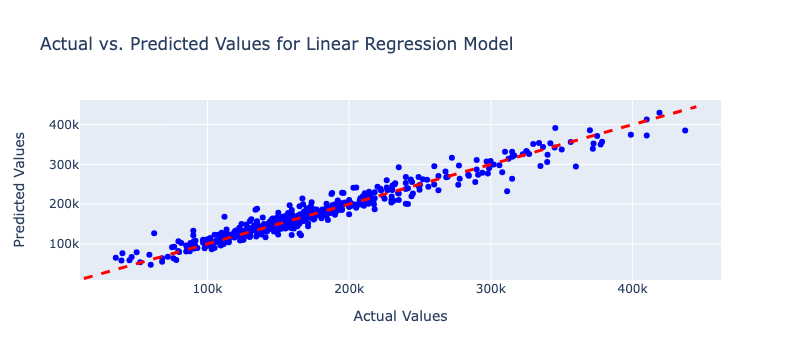

In [73]:
# Create a scatter plot with Plotly
fig = go.Figure()

# Add a scatter plot for actual vs. predicted values
fig.add_trace(go.Scatter(x=y_test, y=best_pred, mode='markers', marker=dict(color='blue'), 
                         name='Actual vs. Predicted'))
# Add a diagonal line for perfect predictions
fig.add_shape(type="line", x0=min(y), x1=max(y), y0=min(y), y1=max(y),
              line=dict(color="red", width=3, dash='dash'),
              name="Perfect Predictions")

# Update layout and axis labels
fig.update_layout(title="Actual vs. Predicted Values for Linear Regression Model",
                  xaxis_title="Actual Values",
                  yaxis_title="Predicted Values")

# Show the plot
fig.show()

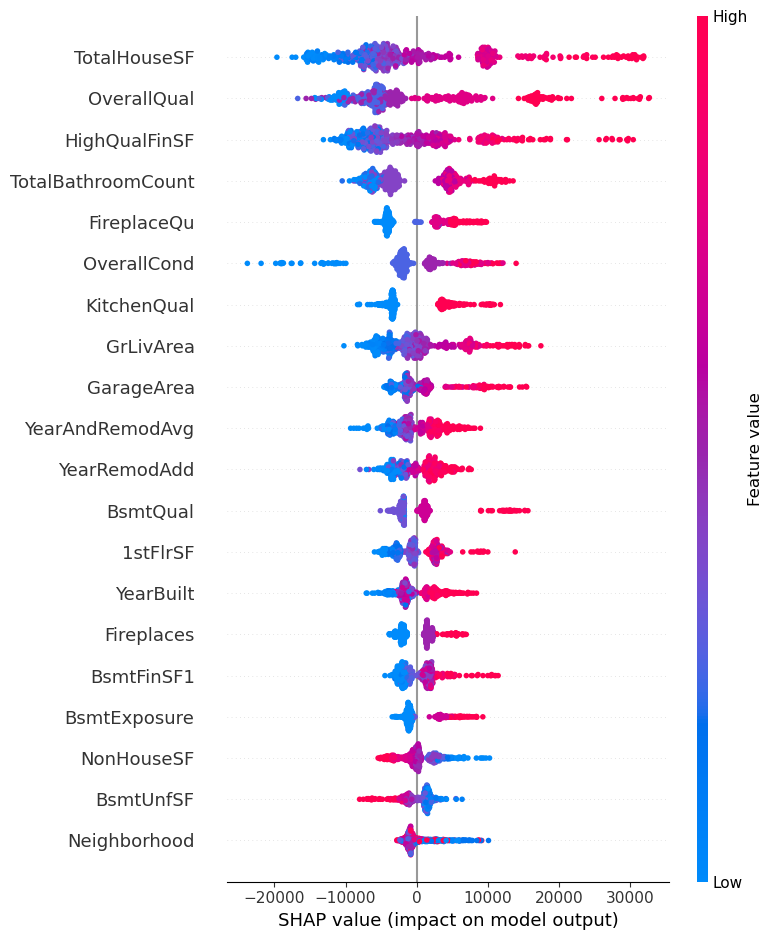

In [72]:
import shap

# Use the SHAP explainer
explainer = shap.Explainer(best_model)

# Calculate SHAP values for a subset of the data (e.g., test set)
shap_values = explainer.shap_values(X_test)

# Plot summary plot
shap.summary_plot(shap_values, X_test)


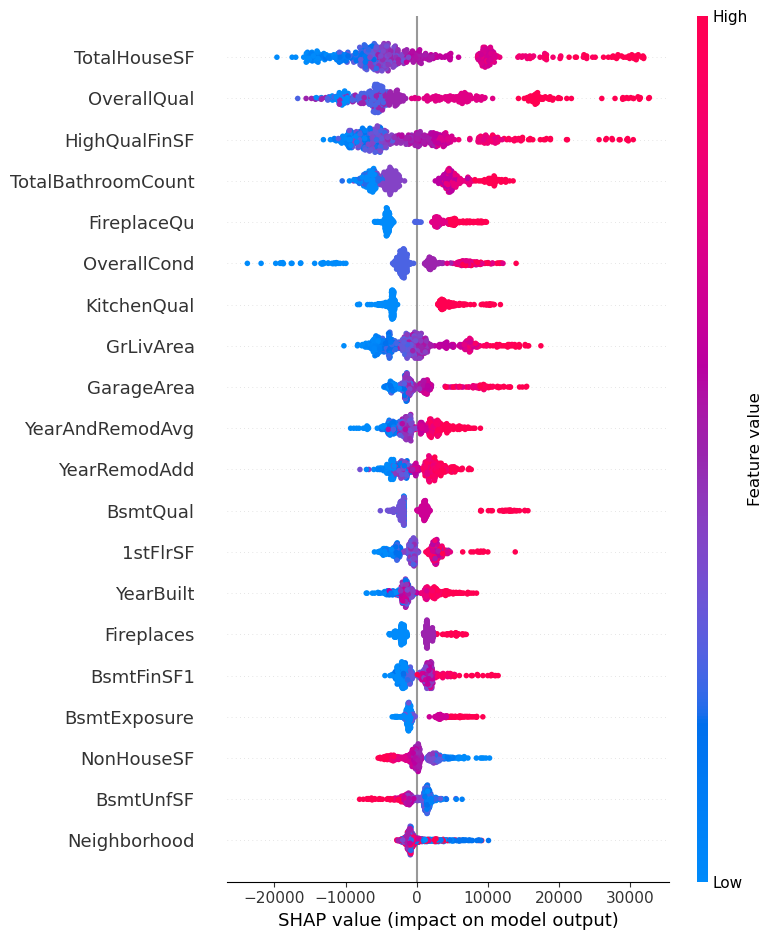

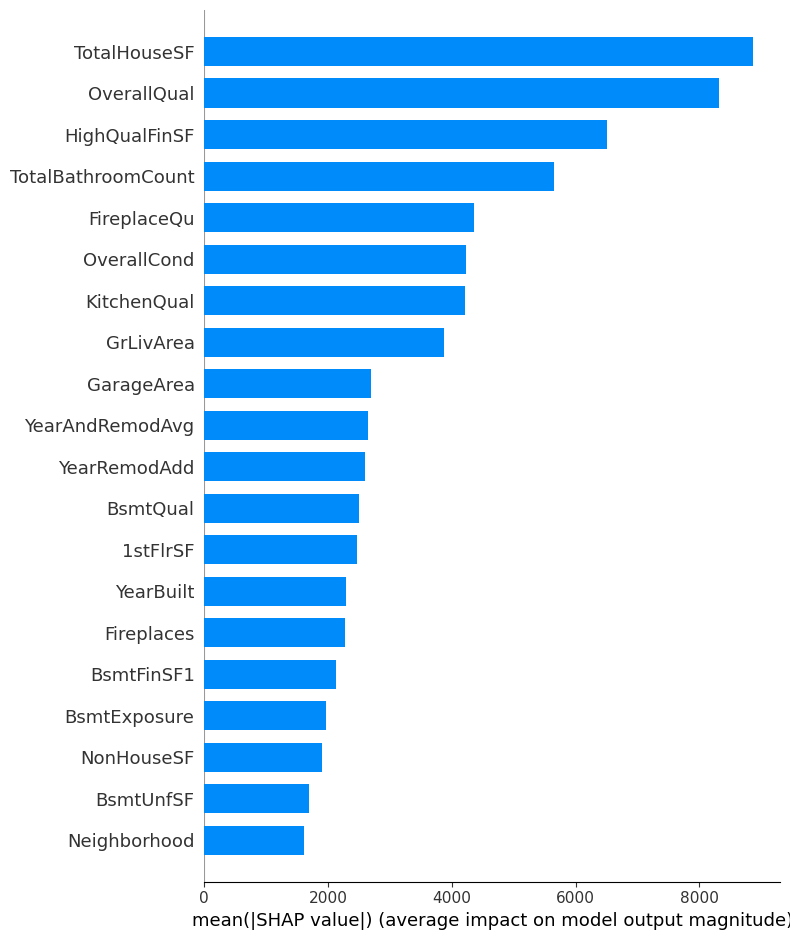

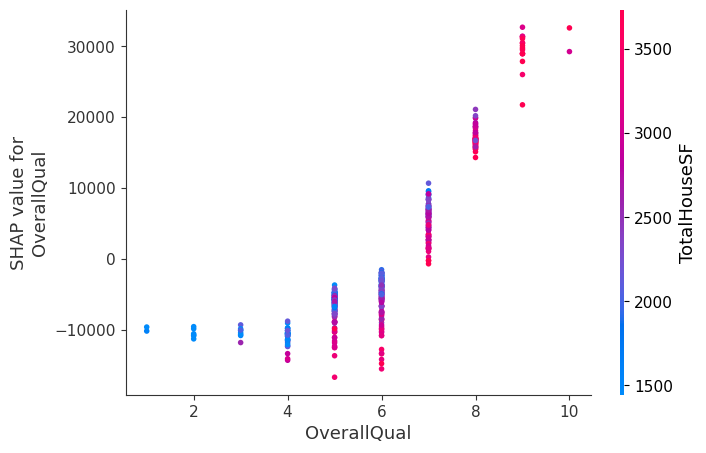

TypeError: Explanation.__init__() got an unexpected keyword argument 'objective'

In [70]:
# Use the SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for a subset of the data (e.g., test set)
shap_values = explainer.shap_values(X_test)

# 1. Summary Plot
shap.summary_plot(shap_values, X_test)

# 2. Summary Bar Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 3. Dependence Plot
shap.dependence_plot("OverallQual", shap_values, X_test)

# 4. Force Plot (for a specific prediction)
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

# 5. Waterfall Plot (for a specific prediction)
shap.waterfall_plot(shap.Explanation(objective="regression", values=shap_values[0, :], base_values=explainer.expected_value), max_display=10)


In [62]:
masterScores

Model  r2_5kf_mean  rmse_5kf_mean
0        catboost     0.919533   18889.778029
1  catboost_tuned     0.927884   17747.628941

In [64]:
output_file = 'masterScores_catboost.csv'

masterScores.to_csv(output_file, index=False, mode='w')

print(f"DataFrame exported to '{output_file}' in the same working directory.")

DataFrame exported to 'masterScores_catboost.csv' in the same working directory.
